In [1]:
import os
import logging
import dill as pickle
import urllib
import random
from tqdm import tqdm
import sys
import codecs
import spacy
import time

import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tarfile
import torchtext.data
import torchtext.datasets

import argparse

In [2]:
device = torch.device("cuda", index=2)
output_dir = './Adam_outputs/lambda=0.3/'
lambda_ = 0.3

In [3]:
_TRAIN_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/" \
             "training-parallel-nc-v12.tgz",
     "trg": "news-commentary-v12.de-en.en",
     "src": "news-commentary-v12.de-en.de"}
    ]

_VAL_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/dev.tgz",
     "trg": "newstest2013.en",
     "src": "newstest2013.de"}]

_TEST_DATA_SOURCES = [
    {"url": "https://storage.googleapis.com/tf-perf-public/" \
                "official_transformer/test_data/newstest2014.tgz",
     "trg": "newstest2014.en",
     "src": "newstest2014.de"}]

In [4]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def file_exist(dir_name, file_name):
    for sub_dir, _, files in os.walk(dir_name):
        if file_name in files:
            return os.path.join(sub_dir, file_name)
    return None

In [5]:
def download_and_extract(download_dir, url, src_filename, trg_filename):
    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        sys.stderr.write(f"Already downloaded and extracted {url}.\n")
        return src_path, trg_path

    compressed_file = _download_file(download_dir, url)

    sys.stderr.write(f"Extracting {compressed_file}.\n")
    with tarfile.open(compressed_file, "r:gz") as corpus_tar:
        corpus_tar.extractall(download_dir)

    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        return src_path, trg_path

    raise OSError(f"Download/extraction failed for url {url} to path {download_dir}")

def _download_file(download_dir, url):
    filename = url.split("/")[-1]
    if file_exist(download_dir, filename):
        sys.stderr.write(f"Already downloaded: {url} (at {filename}).\n")
    else:
        sys.stderr.write(f"Downloading from {url} to {filename}.\n")
        with TqdmUpTo(unit='B', unit_scale=True, miniters=1, desc=filename) as t:
            urllib.request.urlretrieve(url, filename=filename, reporthook=t.update_to)
    return filename

def get_raw_files(raw_dir, sources):
    raw_files = { "src": [], "trg": [], }
    for d in sources:
        src_file, trg_file = download_and_extract(raw_dir, d["url"], d["src"], d["trg"])
        raw_files["src"].append(src_file)
        raw_files["trg"].append(trg_file)
    return raw_files

In [6]:
def mkdir_if_needed(dir_name):
    if not os.path.isdir(dir_name):
        os.makedirs(dir_name)

In [7]:
def compile_files(raw_dir, raw_files, prefix):
    src_fpath = os.path.join(raw_dir, f"raw-{prefix}.src")
    trg_fpath = os.path.join(raw_dir, f"raw-{prefix}.trg")

    if os.path.isfile(src_fpath) and os.path.isfile(trg_fpath):
        sys.stderr.write(f"Merged files found, skip the merging process.\n")
        return src_fpath, trg_fpath

    sys.stderr.write(f"Merge files into two files: {src_fpath} and {trg_fpath}.\n")

    with open(src_fpath, 'w') as src_outf, open(trg_fpath, 'w') as trg_outf:
        for src_inf, trg_inf in zip(raw_files['src'], raw_files['trg']):
            sys.stderr.write(f'  Input files: \n'\
                    f'    - SRC: {src_inf}, and\n' \
                    f'    - TRG: {trg_inf}.\n')
            with open(src_inf, newline='\n') as src_inf, open(trg_inf, newline='\n') as trg_inf:
                cntr = 0
                for i, line in enumerate(src_inf):
                    cntr += 1
                    src_outf.write(line.replace('\r', ' ').strip() + '\n')
                for j, line in enumerate(trg_inf):
                    cntr -= 1
                    trg_outf.write(line.replace('\r', ' ').strip() + '\n')
                assert cntr == 0, 'Number of lines in two files are inconsistent.'
    return src_fpath, trg_fpath

In [8]:
def encode_file(bpe, in_file, out_file):
    sys.stderr.write(f"Read raw content from {in_file} and \n"\
            f"Write encoded content to {out_file}\n")
    
    with codecs.open(in_file, encoding='utf-8') as in_f:
        with codecs.open(out_file, 'w', encoding='utf-8') as out_f:
            for line in in_f:
                out_f.write(bpe.process_line(line))

def encode_files(bpe, src_in_file, trg_in_file, data_dir, prefix):
    src_out_file = os.path.join(data_dir, f"{prefix}.src")
    trg_out_file = os.path.join(data_dir, f"{prefix}.trg")

    if os.path.isfile(src_out_file) and os.path.isfile(trg_out_file):
        sys.stderr.write(f"Encoded files found, skip the encoding process ...\n")

    encode_file(bpe, src_in_file, src_out_file)
    encode_file(bpe, trg_in_file, trg_out_file)
    return src_out_file, trg_out_file

In [9]:
src_lang_model = spacy.load('de_core_news_sm')
trg_lang_model = spacy.load('en_core_web_sm')

In [10]:
PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
BOS_WORD = '<s>'
EOS_WORD = '</s>'

In [11]:
def tokenize_src(text):
        return [tok.text for tok in src_lang_model.tokenizer(text)]

def tokenize_trg(text):
    return [tok.text for tok in trg_lang_model.tokenizer(text)]

SRC = torchtext.legacy.data.Field(
    tokenize=tokenize_src, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

TRG = torchtext.legacy.data.Field(
    tokenize=tokenize_trg, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

In [12]:
MAX_LEN = 100
MIN_FREQ = 3

In [13]:
def filter_examples_with_length(x):
    return len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN

In [14]:
ROOT = '../Datasets/Multi30k/'
train, val, test = torchtext.legacy.datasets.Multi30k.splits(
            root=ROOT,
            exts = ('.' + 'de', '.' + 'en'),
            fields = (SRC, TRG),
            filter_pred=filter_examples_with_length)

In [15]:
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
print('[Info] Get source language vocabulary size:', len(SRC.vocab))
TRG.build_vocab(train.trg, min_freq=MIN_FREQ)
print('[Info] Get target language vocabulary size:', len(TRG.vocab))

[Info] Get source language vocabulary size: 5374
[Info] Get target language vocabulary size: 4556


In [16]:
print('[Info] Merging two vocabulary ...')
for w, _ in SRC.vocab.stoi.items():
    if w not in TRG.vocab.stoi:
        TRG.vocab.stoi[w] = len(TRG.vocab.stoi)
TRG.vocab.itos = [None] * len(TRG.vocab.stoi)
for w, i in TRG.vocab.stoi.items():
    TRG.vocab.itos[i] = w
SRC.vocab.stoi = TRG.vocab.stoi
SRC.vocab.itos = TRG.vocab.itos
print('[Info] Get merged vocabulary size:', len(TRG.vocab))

[Info] Merging two vocabulary ...
[Info] Get merged vocabulary size: 9521


In [17]:
spacy_support_langs = ['de', 'el', 'en', 'es', 'fr', 'it', 'lt', 'nb', 'nl', 'pt']

parser = argparse.ArgumentParser()
parser.add_argument('-lang_src', required=True, choices=spacy_support_langs)
parser.add_argument('-lang_trg', required=True, choices=spacy_support_langs)
parser.add_argument('-save_data', required=True)
parser.add_argument('-data_src', type=str, default=None)
parser.add_argument('-data_trg', type=str, default=None)

parser.add_argument('-max_len', type=int, default=100)
parser.add_argument('-min_word_count', type=int, default=3)
parser.add_argument('-keep_case', action='store_true')
parser.add_argument('-share_vocab', action='store_true')

opt = parser.parse_args(args=['-lang_src', 'de', '-lang_trg', 'en', '-share_vocab', '-save_data', './m30k_deen_shr.pkl'])

In [18]:
data = {
    'settings': opt,
    'vocab': {'src': SRC, 'trg': TRG},
    'train': train.examples,
    'valid': val.examples,
    'test': test.examples}

print('[Info] Dumping the processed data to pickle file', opt.save_data)
pickle.dump(data, open(opt.save_data, 'wb'))

[Info] Dumping the processed data to pickle file ./m30k_deen_shr.pkl


# 学習設定

In [19]:
parser = argparse.ArgumentParser()

parser.add_argument('-data_pkl', default=None)     # all-in-1 data pickle or bpe field
parser.add_argument('-train_path', default=None)   # bpe encoded data
parser.add_argument('-val_path', default=None)     # bpe encoded data
parser.add_argument('-epoch', type=int, default=10)
parser.add_argument('-b', '--batch_size', type=int, default=2048)
parser.add_argument('-d_model', type=int, default=512)
parser.add_argument('-d_inner_hid', type=int, default=2048)
parser.add_argument('-d_k', type=int, default=64)
parser.add_argument('-d_v', type=int, default=64)
parser.add_argument('-n_head', type=int, default=8)
parser.add_argument('-n_layers', type=int, default=6)
parser.add_argument('-warmup','--n_warmup_steps', type=int, default=4000)
parser.add_argument('-lr_mul', type=float, default=2.0)
parser.add_argument('-seed', type=int, default=None)
parser.add_argument('-dropout', type=float, default=0.1)
parser.add_argument('-embs_share_weight', action='store_true')
parser.add_argument('-proj_share_weight', action='store_true')
parser.add_argument('-scale_emb_or_prj', type=str, default='prj')
parser.add_argument('-output_dir', type=str, default=None)
parser.add_argument('-use_tb', action='store_true')
parser.add_argument('-save_mode', type=str, choices=['all', 'best'], default='best')
parser.add_argument('-no_cuda', action='store_true')
parser.add_argument('-label_smoothing', action='store_true')

opt = parser.parse_args(
    args=['-data_pkl', './m30k_deen_shr.pkl', '-seed', '428', '-embs_share_weight', '-proj_share_weight', '-label_smoothing', '-output_dir', output_dir, '-b', '512', '-warmup', '128000', '-epoch', '1000'])
opt.cuda = not opt.no_cuda
opt.d_word_vec = opt.d_model

In [20]:
if opt.seed is not None:
    torch.manual_seed(opt.seed)
    torch.backends.cudnn.benchmark = False
    np.random.seed(opt.seed)
    random.seed(opt.seed)

In [21]:
if opt.batch_size < 2048 and opt.n_warmup_steps <= 4000:
    print('[Warning] The warmup steps may be not enough.\n'\
            '(sz_b, warmup) = (2048, 4000) is the official setting.\n'\
            'Using smaller batch w/o longer warmup may cause '\
            'the warmup stage ends with only little data trained.')

In [22]:
def prepare_dataloaders(opt, device):
    batch_size = opt.batch_size
    data = pickle.load(open(opt.data_pkl, 'rb'))

    opt.max_token_seq_len = data['settings'].max_len
    opt.src_pad_idx = data['vocab']['src'].vocab.stoi[PAD_WORD]
    opt.trg_pad_idx = data['vocab']['trg'].vocab.stoi[PAD_WORD]

    opt.src_vocab_size = len(data['vocab']['src'].vocab)
    opt.trg_vocab_size = len(data['vocab']['trg'].vocab)

    if opt.embs_share_weight:
        assert data['vocab']['src'].vocab.stoi == data['vocab']['trg'].vocab.stoi, \
            'To sharing word embedding the src/trg word2idx table shall be the same.'

    fields = {'src': data['vocab']['src'], 'trg':data['vocab']['trg']}

    train = torchtext.legacy.data.Dataset(examples=data['train'], fields=fields)
    val = torchtext.legacy.data.Dataset(examples=data['valid'], fields=fields)

    train_iterator = torchtext.legacy.data.BucketIterator(train, batch_size=batch_size, device=device, train=True)
    val_iterator = torchtext.legacy.data.BucketIterator(val, batch_size=batch_size, device=device)

    return train_iterator, val_iterator

In [23]:
training_data, validation_data = prepare_dataloaders(opt, device)

# Gate 付き Transformer の実装と実体化

In [24]:
class BinaryGate(nn.Module):
    
    def __init__(self, num_gates: int, init: float=0.0):
        super(BinaryGate, self).__init__()
        
        self.num_gates = num_gates
        self.gate = nn.parameter.Parameter(torch.zeros(num_gates).fill_(init))
    
    def forward(self, beta=0.667, gamma=-0.1, zeta = 1.0, 
                hard = True, eps = 1e-6, threshold=0.5):
        
        loss_constant = (beta * math.log(-gamma / zeta)) if (gamma < 0) else 0.0
        
        if self.training:
            noise = torch.zeros(self.num_gates)
            noise = noise.cuda(self.gate.device)
            
            noise.data.uniform_(eps, 1 - eps)
            u = noise.data
            
            s = torch.log(u) - torch.log(1.0 - u)
            
            s = (s + self.gate) / beta
            s = torch.sigmoid(s)
        else:
            s = torch.sigmoid(self.gate)
        
        s = s * (zeta - gamma) + gamma
        out = torch.clamp(s, eps, 1)
        
        if hard:
            out_hard = torch.greater_equal(out, threshold).float()
            out = out + (out_hard - out).detach()
            sparsity = torch.eq(out, 0).sum()
        else:
            sparsity = torch.less(out, threshold).float().sum()
        
        l0_loss = torch.sigmoid(self.gate - loss_constant)
        l0_loss = torch.clamp(l0_loss, eps, 1.0 - eps).sum()
        
        return out, l0_loss, (sparsity.detach().cpu(), self.num_gates)

In [25]:
class ScaledDotProductAttention(nn.Module):

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn

In [26]:
class MultiHeadAttention(nn.Module):

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.gate = BinaryGate(num_gates=n_head, init=2.0)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q
        
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)
        
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
        
        bin_mask, l0_loss, sparsity = self.gate()
        bin_mask = torch.cat([bin_mask[i].repeat(self.d_model//self.n_head) for i in range(self.n_head)])
        
        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)
        
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q *= bin_mask
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn, l0_loss, sparsity


class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x

In [27]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        enc_output, enc_slf_attn, l0_loss, sparsity = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output = self.pos_ffn(enc_output)
        
        return enc_output, enc_slf_attn, l0_loss, sparsity


class DecoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(
            self, dec_input, enc_output,
            slf_attn_mask=None, dec_enc_attn_mask=None):
        dec_output, dec_slf_attn, l0_loss1, sparsity1 = self.slf_attn(
            dec_input, dec_input, dec_input, mask=slf_attn_mask)
        dec_output, dec_enc_attn, l0_loss2, sparsity2 = self.enc_attn(
            dec_output, enc_output, enc_output, mask=dec_enc_attn_mask)
        dec_output = self.pos_ffn(dec_output)
        
        return dec_output, dec_slf_attn, dec_enc_attn, l0_loss1+l0_loss2, sparsity1, sparsity2

In [28]:
def get_pad_mask(seq, pad_idx):
    return (seq != pad_idx).unsqueeze(-2)


def get_subsequent_mask(seq):
    sz_b, len_s = seq.size()
    subsequent_mask = (1 - torch.triu(
        torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
    return subsequent_mask


class PositionalEncoding(nn.Module):

    def __init__(self, d_hid, n_position=200):
        super(PositionalEncoding, self).__init__()
        
        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_position, d_hid))

    def _get_sinusoid_encoding_table(self, n_position, d_hid):

        def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()


class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(
            self, n_src_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, dropout=0.1, n_position=200, scale_emb=False):

        super().__init__()

        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, src_seq, src_mask, return_attns=False):

        enc_slf_attn_list = []
        l0_loss = 0.0
        sparsity = [0, 0]
        
        enc_output = self.src_word_emb(src_seq)
        if self.scale_emb:
            enc_output *= self.d_model ** 0.5
        enc_output = self.dropout(self.position_enc(enc_output))
        enc_output = self.layer_norm(enc_output)

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn, l0, spa = enc_layer(enc_output, slf_attn_mask=src_mask)
            enc_slf_attn_list += [enc_slf_attn] if return_attns else []
            l0_loss += l0
            sparsity[0] += spa[0]
            sparsity[1] += spa[1]

        if return_attns:
            return enc_output, l0_loss, sparsity, enc_slf_attn_list
        return enc_output, l0_loss, sparsity,


class Decoder(nn.Module):

    def __init__(
            self, n_trg_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, n_position=200, dropout=0.1, scale_emb=False):

        super().__init__()

        self.trg_word_emb = nn.Embedding(n_trg_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, trg_seq, trg_mask, enc_output, src_mask, return_attns=False):

        dec_slf_attn_list, dec_enc_attn_list = [], []
        l0_loss = 0.0
        sparsity1 = [0, 0]
        sparsity2 = [0, 0]
        
        dec_output = self.trg_word_emb(trg_seq)
        if self.scale_emb:
            dec_output *= self.d_model ** 0.5
        dec_output = self.dropout(self.position_enc(dec_output))
        dec_output = self.layer_norm(dec_output)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn, l0, spa1, spa2 = dec_layer(
                dec_output, enc_output, slf_attn_mask=trg_mask, dec_enc_attn_mask=src_mask)
            dec_slf_attn_list += [dec_slf_attn] if return_attns else []
            dec_enc_attn_list += [dec_enc_attn] if return_attns else []
            l0_loss += l0
            sparsity1[0] += spa1[0]
            sparsity1[1] += spa1[1]
            sparsity2[0] += spa2[0]
            sparsity2[1] += spa2[1]

        if return_attns:
            return dec_output, l0_loss, sparsity1, sparsity2, dec_slf_attn_list, dec_enc_attn_list
        return dec_output, l0_loss, sparsity1, sparsity2,

In [29]:
class Transformer(nn.Module):

    def __init__(
            self, n_src_vocab, n_trg_vocab, src_pad_idx, trg_pad_idx,
            d_word_vec=512, d_model=512, d_inner=2048,
            n_layers=6, n_head=8, d_k=64, d_v=64, dropout=0.1, n_position=200,
            trg_emb_prj_weight_sharing=True, emb_src_trg_weight_sharing=True,
            scale_emb_or_prj='prj'):

        super().__init__()

        self.src_pad_idx, self.trg_pad_idx = src_pad_idx, trg_pad_idx

        assert scale_emb_or_prj in ['emb', 'prj', 'none']
        scale_emb = (scale_emb_or_prj == 'emb') if trg_emb_prj_weight_sharing else False
        self.scale_prj = (scale_emb_or_prj == 'prj') if trg_emb_prj_weight_sharing else False
        self.d_model = d_model

        self.encoder = Encoder(
            n_src_vocab=n_src_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=src_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.decoder = Decoder(
            n_trg_vocab=n_trg_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=trg_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.trg_word_prj = nn.Linear(d_model, n_trg_vocab, bias=False)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p) 

        assert d_model == d_word_vec, \
        'To facilitate the residual connections, \
         the dimensions of all module outputs shall be the same.'

        if trg_emb_prj_weight_sharing:
            self.trg_word_prj.weight = self.decoder.trg_word_emb.weight

        if emb_src_trg_weight_sharing:
            self.encoder.src_word_emb.weight = self.decoder.trg_word_emb.weight


    def forward(self, src_seq, trg_seq):

        src_mask = get_pad_mask(src_seq, self.src_pad_idx)
        trg_mask = get_pad_mask(trg_seq, self.trg_pad_idx) & get_subsequent_mask(trg_seq)

        enc_output, l0_loss1, sparsity1, *_ = self.encoder(src_seq, src_mask)
        dec_output, l0_loss2, sparsity2, sparsity3, *_ = self.decoder(trg_seq, trg_mask, enc_output, src_mask)
        seq_logit = self.trg_word_prj(dec_output)
        if self.scale_prj:
            seq_logit *= self.d_model ** -0.5

        return seq_logit.view(-1, seq_logit.size(2)), l0_loss1+l0_loss2, (sparsity1, sparsity2, sparsity3)

In [30]:
transformer = Transformer(
        opt.src_vocab_size,
        opt.trg_vocab_size,
        src_pad_idx=opt.src_pad_idx,
        trg_pad_idx=opt.trg_pad_idx,
        trg_emb_prj_weight_sharing=opt.proj_share_weight,
        emb_src_trg_weight_sharing=opt.embs_share_weight,
        d_k=opt.d_k,
        d_v=opt.d_v,
        d_model=opt.d_model,
        d_word_vec=opt.d_word_vec,
        d_inner=opt.d_inner_hid,
        n_layers=opt.n_layers,
        n_head=opt.n_head,
        dropout=opt.dropout,
        scale_emb_or_prj=opt.scale_emb_or_prj).to(device)

# Optimizer の実装と実体化

In [31]:
optimizer = optim.Adam(transformer.parameters(), betas=(0.9, 0.98), eps=1e-09)

# 訓練と検証

In [32]:
def cal_performance(pred, gold, trg_pad_idx, smoothing=False):

    loss = cal_loss(pred, gold, trg_pad_idx, smoothing=smoothing)

    pred = pred.max(1)[1]
    gold = gold.contiguous().view(-1)
    non_pad_mask = gold.ne(trg_pad_idx)
    n_correct = pred.eq(gold).masked_select(non_pad_mask).sum().item()
    n_word = non_pad_mask.sum().item()

    return loss, n_correct, n_word


def cal_loss(pred, gold, trg_pad_idx, smoothing=False):

    gold = gold.contiguous().view(-1)

    if smoothing:
        eps = 0.1
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        non_pad_mask = gold.ne(trg_pad_idx)
        loss = -(one_hot * log_prb).sum(dim=1)
        loss = loss.masked_select(non_pad_mask).sum()  # average later
    else:
        loss = F.cross_entropy(pred, gold, ignore_index=trg_pad_idx, reduction='sum')
    return loss


def patch_src(src, pad_idx):
    src = src.transpose(0, 1)
    return src


def patch_trg(trg, pad_idx):
    trg = trg.transpose(0, 1)
    trg, gold = trg[:, :-1], trg[:, 1:].contiguous().view(-1)
    return trg, gold


def train_epoch(model, training_data, optimizer, opt, device, smoothing, lambda_):

    model.train()
    total_loss, n_word_total, n_word_correct = 0, 0, 0 
    enc_sparsity = [0, 0]
    dec_sparsity1 = [0, 0]
    dec_sparsity2 = [0, 0]
    
    desc = '  - (Training)   '
    for batch in tqdm(training_data, mininterval=2, desc=desc, leave=False):
        
        src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
        trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

        # forward
        optimizer.zero_grad()
        pred, l0_loss, sparsity = model(src_seq, trg_seq)

        # backward and update parameters
        loss, n_correct, n_word = cal_performance(
            pred, gold, opt.trg_pad_idx, smoothing=smoothing)
        loss_ = loss + lambda_ * l0_loss
        loss_.backward()

        # note keeping
        n_word_total += n_word
        n_word_correct += n_correct
        total_loss += loss.item()
        enc_sparsity[0] += sparsity[0][0]
        enc_sparsity[1] += sparsity[0][1]
        dec_sparsity1[0] += sparsity[1][0]
        dec_sparsity1[1] += sparsity[1][1]
        dec_sparsity2[0] += sparsity[2][0]
        dec_sparsity2[1] += sparsity[2][1]
        

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy, (enc_sparsity, dec_sparsity1, dec_sparsity2)


def eval_epoch(model, validation_data, device, opt, lambda_):

    model.eval()
    total_loss, n_word_total, n_word_correct = 0, 0, 0

    desc = '  - (Validation) '
    with torch.no_grad():
        for batch in tqdm(validation_data, mininterval=2, desc=desc, leave=False):

            # prepare data
            src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
            trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

            # forward
            pred, l0_loss, sparsity = model(src_seq, trg_seq)
            loss, n_correct, n_word = cal_performance(
                pred, gold, opt.trg_pad_idx, smoothing=False)
            
            # note keeping
            n_word_total += n_word
            n_word_correct += n_correct
            total_loss += loss.item()

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy

In [33]:
def train(model, training_data, validation_data, optimizer, device, opt, lambda_=0.0):
    if opt.use_tb:
        print("[Info] Use Tensorboard")
        from torch.utils.tensorboard import SummaryWriter
        tb_writer = SummaryWriter(log_dir=os.path.join(opt.output_dir, 'tensorboard'))

    log_train_file = os.path.join(opt.output_dir, 'train.log')
    log_valid_file = os.path.join(opt.output_dir, 'valid.log')
    log_sparsity_file = os.path.join(opt.output_dir, 'sparsity.log')

    print('[Info] Training performance will be written to file: {} and {}'.format(
        log_train_file, log_valid_file, log_sparsity_file))

    with open(log_train_file, 'w') as log_tf, open(log_valid_file, 'w') as log_vf, open(log_sparsity_file, 'w') as log_sf:
        log_tf.write('epoch,loss,ppl,accuracy\n')
        log_vf.write('epoch,loss,ppl,accuracy\n')
        log_sf.write('epoch,enc-sa,dec-sa, dec-enc\n')

    def print_performances(header, ppl, accu, start_time, lr):
        print('  - {header:12} ppl: {ppl: 8.5f}, accuracy: {accu:3.3f} %, lr: {lr:8.5f}, '\
              'elapse: {elapse:3.3f} min'.format(
                  header=f"({header})", ppl=ppl,
                  accu=100*accu, elapse=(time.time()-start_time)/60, lr=lr))

    valid_losses = []
    for epoch_i in range(opt.epoch):
        print('[ Epoch', epoch_i, ']')

        start = time.time()
        train_loss, train_accu, sparsity = train_epoch(
            model, training_data, optimizer, opt, device, smoothing=opt.label_smoothing, lambda_=lambda_)
        train_ppl = math.exp(min(train_loss, 100))
        lr = 0.001
        print_performances('Training', train_ppl, train_accu, start, lr)

        start = time.time()
        valid_loss, valid_accu = eval_epoch(model, validation_data, device, opt, lambda_=lambda_)
        valid_ppl = math.exp(min(valid_loss, 100))
        print_performances('Validation', valid_ppl, valid_accu, start, lr)

        valid_losses += [valid_loss]

        checkpoint = {'epoch': epoch_i, 'settings': opt, 'model': model.state_dict()}

        if opt.save_mode == 'all':
            model_name = 'model_accu_{accu:3.3f}.chkpt'.format(accu=100*valid_accu)
            torch.save(checkpoint, model_name)
        elif opt.save_mode == 'best':
            model_name = 'model.chkpt'
            if valid_loss <= min(valid_losses):
                torch.save(checkpoint, os.path.join(opt.output_dir, model_name))
                print('    - [Info] The checkpoint file has been updated.')

        with open(log_train_file, 'a') as log_tf, open(log_valid_file, 'a') as log_vf, open(log_sparsity_file, 'a') as log_sf:
            log_tf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=train_loss,
                ppl=train_ppl, accu=100*train_accu))
            log_vf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=valid_loss,
                ppl=valid_ppl, accu=100*valid_accu))
            log_sf.write('{epoch},{enc: 3.3f},{dec1: 3.3f},{dec2: 3.3f}\n'.format(
                epoch=epoch_i, 
                enc =(sparsity[0][1]-sparsity[0][0])/sparsity[0][1],
                dec1=(sparsity[1][1]-sparsity[1][0])/sparsity[1][1],
                dec2=(sparsity[2][1]-sparsity[2][0])/sparsity[2][1]))

        if opt.use_tb:
            tb_writer.add_scalars('ppl', {'train': train_ppl, 'val': valid_ppl}, epoch_i)
            tb_writer.add_scalars('accuracy', {'train': train_accu*100, 'val': valid_accu*100}, epoch_i)
            tb_writer.add_scalar('learning_rate', lr, epoch_i)

In [34]:
train(transformer, training_data, validation_data, optimizer, device, opt, lambda_=lambda_)

[Info] Training performance will be written to file: ./Adam_outputs/lambda=0.3/train.log and ./Adam_outputs/lambda=0.3/valid.log
[ Epoch 0 ]


  - (Training)   ppl:  9503.07894, accuracy: 0.005 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 1 ]


  - (Training)   ppl:  9503.33804, accuracy: 0.004 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 2 ]


  - (Training)   ppl:  9504.32097, accuracy: 0.009 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 3 ]


  - (Training)   ppl:  9505.11163, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 4 ]


  - (Training)   ppl:  9501.39552, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 5 ]


  - (Training)   ppl:  9499.47979, accuracy: 0.005 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 6 ]


  - (Training)   ppl:  9500.72153, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 7 ]


  - (Training)   ppl:  9502.02911, accuracy: 0.007 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 8 ]


  - (Training)   ppl:  9501.73285, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 9 ]


  - (Training)   ppl:  9502.70709, accuracy: 0.006 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 10 ]


  - (Training)   ppl:  9504.02056, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 11 ]


  - (Training)   ppl:  9504.42948, accuracy: 0.004 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.16838, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 12 ]


  - (Training)   ppl:  9501.30908, accuracy: 0.004 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 13 ]


  - (Training)   ppl:  9499.12296, accuracy: 0.007 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 14 ]


  - (Training)   ppl:  9499.96234, accuracy: 0.009 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 15 ]


  - (Training)   ppl:  9504.36307, accuracy: 0.008 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 16 ]


  - (Training)   ppl:  9501.09476, accuracy: 0.005 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 17 ]


  - (Training)   ppl:  9502.08299, accuracy: 0.005 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.16581, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 18 ]


  - (Training)   ppl:  9503.23117, accuracy: 0.003 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 19 ]


  - (Training)   ppl:  9498.17175, accuracy: 0.005 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 20 ]


  - (Training)   ppl:  9500.38052, accuracy: 0.006 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 21 ]


  - (Training)   ppl:  9501.26373, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 22 ]


  - (Training)   ppl:  9503.23943, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.16581, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 23 ]


  - (Training)   ppl:  9500.80171, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 24 ]


  - (Training)   ppl:  9500.83245, accuracy: 0.009 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 25 ]


  - (Training)   ppl:  9502.35966, accuracy: 0.007 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 26 ]


  - (Training)   ppl:  9501.42110, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 27 ]


  - (Training)   ppl:  9504.40054, accuracy: 0.006 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 28 ]


  - (Training)   ppl:  9500.44183, accuracy: 0.005 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 29 ]


  - (Training)   ppl:  9501.31253, accuracy: 0.006 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 30 ]


  - (Training)   ppl:  9501.90874, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 31 ]


  - (Training)   ppl:  9506.03903, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 32 ]


  - (Training)   ppl:  9501.05176, accuracy: 0.006 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 33 ]


  - (Training)   ppl:  9500.58322, accuracy: 0.004 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 34 ]


  - (Training)   ppl:  9503.09527, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 35 ]


  - (Training)   ppl:  9498.80657, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 36 ]


  - (Training)   ppl:  9500.72933, accuracy: 0.008 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 37 ]


  - (Training)   ppl:  9503.94589, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 38 ]


  - (Training)   ppl:  9501.18763, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 39 ]


  - (Training)   ppl:  9502.28645, accuracy: 0.004 %, lr:  0.00100, elapse: 0.306 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 40 ]


  - (Training)   ppl:  9502.70373, accuracy: 0.010 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 41 ]


  - (Training)   ppl:  9501.72505, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 42 ]


  - (Training)   ppl:  9501.17811, accuracy: 0.004 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 43 ]


  - (Training)   ppl:  9498.93824, accuracy: 0.006 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 44 ]


  - (Training)   ppl:  9500.19297, accuracy: 0.006 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 45 ]


  - (Training)   ppl:  9501.89504, accuracy: 0.003 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 46 ]


  - (Training)   ppl:  9502.03963, accuracy: 0.006 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 47 ]


  - (Training)   ppl:  9500.85495, accuracy: 0.004 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 48 ]


  - (Training)   ppl:  9499.36880, accuracy: 0.002 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 49 ]


  - (Training)   ppl:  9504.14822, accuracy: 0.008 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 50 ]


  - (Training)   ppl:  9499.85578, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 51 ]


  - (Training)   ppl:  9501.07127, accuracy: 0.003 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 52 ]


  - (Training)   ppl:  9504.51940, accuracy: 0.007 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 53 ]


  - (Training)   ppl:  9502.31693, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 54 ]


  - (Training)   ppl:  9500.83853, accuracy: 0.009 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 55 ]


  - (Training)   ppl:  9499.92851, accuracy: 0.010 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 56 ]


  - (Training)   ppl:  9501.12895, accuracy: 0.002 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.19918, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 57 ]


  - (Training)   ppl:  9505.17851, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 58 ]


  - (Training)   ppl:  9502.97979, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 59 ]


  - (Training)   ppl:  9498.39889, accuracy: 0.006 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19405, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 60 ]


  - (Training)   ppl:  9499.66670, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 61 ]


  - (Training)   ppl:  9501.66473, accuracy: 0.004 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.16838, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 62 ]


  - (Training)   ppl:  9498.50879, accuracy: 0.024 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.19405, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 63 ]


  - (Training)   ppl:  9501.85095, accuracy: 0.004 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 64 ]


  - (Training)   ppl:  9499.88562, accuracy: 0.010 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 65 ]


  - (Training)   ppl:  9503.68887, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 66 ]


  - (Training)   ppl:  9501.10818, accuracy: 0.009 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 67 ]


  - (Training)   ppl:  9503.07341, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 68 ]


  - (Training)   ppl:  9497.81569, accuracy: 0.008 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 69 ]


  - (Training)   ppl:  9501.22401, accuracy: 0.019 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 70 ]


  - (Training)   ppl:  9501.33058, accuracy: 0.003 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 71 ]


  - (Training)   ppl:  9502.30305, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 72 ]


  - (Training)   ppl:  9501.91563, accuracy: 0.007 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 73 ]


  - (Training)   ppl:  9500.22353, accuracy: 0.003 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 74 ]


  - (Training)   ppl:  9500.93812, accuracy: 0.007 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 75 ]


  - (Training)   ppl:  9501.62836, accuracy: 0.006 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 76 ]


  - (Training)   ppl:  9502.69203, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 77 ]


  - (Training)   ppl:  9502.46552, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 78 ]


  - (Training)   ppl:  9501.34990, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 79 ]


  - (Training)   ppl:  9500.84289, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 80 ]


  - (Training)   ppl:  9501.23416, accuracy: 0.003 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 81 ]


  - (Training)   ppl:  9503.38159, accuracy: 0.006 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 82 ]


  - (Training)   ppl:  9501.75208, accuracy: 0.004 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 83 ]


  - (Training)   ppl:  9499.09738, accuracy: 0.009 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 84 ]


  - (Training)   ppl:  9501.49031, accuracy: 0.006 %, lr:  0.00100, elapse: 0.306 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 85 ]


  - (Training)   ppl:  9500.04922, accuracy: 0.006 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 86 ]


  - (Training)   ppl:  9502.72859, accuracy: 0.009 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 87 ]


  - (Training)   ppl:  9502.60885, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 88 ]


  - (Training)   ppl:  9502.36229, accuracy: 0.007 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 89 ]


  - (Training)   ppl:  9499.53366, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 90 ]


  - (Training)   ppl:  9502.84616, accuracy: 0.006 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 91 ]


  - (Training)   ppl:  9499.90421, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 92 ]


  - (Training)   ppl:  9503.45689, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 93 ]


  - (Training)   ppl:  9502.38043, accuracy: 0.005 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 94 ]


  - (Training)   ppl:  9499.92996, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 95 ]


  - (Training)   ppl:  9501.66900, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 96 ]


  - (Training)   ppl:  9503.41143, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 97 ]


  - (Training)   ppl:  9501.25657, accuracy: 0.014 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 98 ]


  - (Training)   ppl:  9500.81168, accuracy: 0.006 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 99 ]


  - (Training)   ppl:  9500.76316, accuracy: 0.008 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 100 ]


  - (Training)   ppl:  9498.18780, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 101 ]


  - (Training)   ppl:  9499.53049, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19918, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 102 ]


  - (Training)   ppl:  9499.57356, accuracy: 0.004 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 103 ]


  - (Training)   ppl:  9500.57587, accuracy: 0.003 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 104 ]


  - (Training)   ppl:  9502.54063, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 105 ]


  - (Training)   ppl:  9502.26994, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 106 ]


  - (Training)   ppl:  9502.19420, accuracy: 0.008 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 107 ]


  - (Training)   ppl:  9504.18487, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 108 ]


  - (Training)   ppl:  9501.05848, accuracy: 0.010 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 109 ]


  - (Training)   ppl:  9500.32919, accuracy: 0.004 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 110 ]


  - (Training)   ppl:  9501.73712, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 111 ]


  - (Training)   ppl:  9500.16630, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 112 ]


  - (Training)   ppl:  9503.59061, accuracy: 0.008 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 113 ]


  - (Training)   ppl:  9500.21709, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 114 ]


  - (Training)   ppl:  9503.24042, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 115 ]


  - (Training)   ppl:  9503.28587, accuracy: 0.007 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 116 ]


  - (Training)   ppl:  9500.90211, accuracy: 0.013 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 117 ]


  - (Training)   ppl:  9502.40492, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 118 ]


  - (Training)   ppl:  9502.54054, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 119 ]


  - (Training)   ppl:  9503.77814, accuracy: 0.008 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 120 ]


  - (Training)   ppl:  9501.60596, accuracy: 0.004 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 121 ]


  - (Training)   ppl:  9499.82885, accuracy: 0.004 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 122 ]


  - (Training)   ppl:  9503.62627, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 123 ]


  - (Training)   ppl:  9503.04465, accuracy: 0.004 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 124 ]


  - (Training)   ppl:  9500.48074, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 125 ]


  - (Training)   ppl:  9500.49316, accuracy: 0.006 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 126 ]


  - (Training)   ppl:  9503.06189, accuracy: 0.006 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 127 ]


  - (Training)   ppl:  9500.99880, accuracy: 0.003 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 128 ]


  - (Training)   ppl:  9504.20120, accuracy: 0.002 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 129 ]


  - (Training)   ppl:  9501.80125, accuracy: 0.002 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 130 ]


  - (Training)   ppl:  9501.03499, accuracy: 0.007 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 131 ]


  - (Training)   ppl:  9501.50754, accuracy: 0.009 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 132 ]


  - (Training)   ppl:  9502.09424, accuracy: 0.004 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 133 ]


  - (Training)   ppl:  9502.85060, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 134 ]


  - (Training)   ppl:  9502.30605, accuracy: 0.007 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 135 ]


  - (Training)   ppl:  9500.68988, accuracy: 0.007 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 136 ]


  - (Training)   ppl:  9500.35921, accuracy: 0.009 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 137 ]


  - (Training)   ppl:  9499.13511, accuracy: 0.004 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 138 ]


  - (Training)   ppl:  9501.55172, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 139 ]


  - (Training)   ppl:  9500.48037, accuracy: 0.008 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 140 ]


  - (Training)   ppl:  9500.70085, accuracy: 0.005 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 141 ]


  - (Training)   ppl:  9503.51722, accuracy: 0.004 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 142 ]


  - (Training)   ppl:  9500.77359, accuracy: 0.006 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 143 ]


  - (Training)   ppl:  9501.95654, accuracy: 0.007 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 144 ]


  - (Training)   ppl:  9502.85432, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 145 ]


  - (Training)   ppl:  9501.73195, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 146 ]


  - (Training)   ppl:  9502.90422, accuracy: 0.007 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 147 ]


  - (Training)   ppl:  9501.13684, accuracy: 0.011 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 148 ]


  - (Training)   ppl:  9501.36722, accuracy: 0.005 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 149 ]


  - (Training)   ppl:  9500.52282, accuracy: 0.006 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 150 ]


  - (Training)   ppl:  9503.09074, accuracy: 0.007 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 151 ]


  - (Training)   ppl:  9503.67771, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 152 ]


  - (Training)   ppl:  9502.98831, accuracy: 0.014 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 153 ]


  - (Training)   ppl:  9499.66497, accuracy: 0.003 %, lr:  0.00100, elapse: 0.307 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 154 ]


  - (Training)   ppl:  9499.99916, accuracy: 0.008 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 155 ]


  - (Training)   ppl:  9501.20605, accuracy: 0.003 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 156 ]


  - (Training)   ppl:  9500.49452, accuracy: 0.009 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 157 ]


  - (Training)   ppl:  9504.60033, accuracy: 0.008 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 158 ]


  - (Training)   ppl:  9500.46205, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 159 ]


  - (Training)   ppl:  9502.97135, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 160 ]


  - (Training)   ppl:  9506.83510, accuracy: 0.005 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.16325, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 161 ]


  - (Training)   ppl:  9501.67861, accuracy: 0.010 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 162 ]


  - (Training)   ppl:  9498.07174, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 163 ]


  - (Training)   ppl:  9502.25797, accuracy: 0.007 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.16581, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 164 ]


  - (Training)   ppl:  9502.38324, accuracy: 0.004 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 165 ]


  - (Training)   ppl:  9502.05215, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 166 ]


  - (Training)   ppl:  9502.15401, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 167 ]


  - (Training)   ppl:  9504.20737, accuracy: 0.006 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 168 ]


  - (Training)   ppl:  9501.86311, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 169 ]


  - (Training)   ppl:  9502.24518, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 170 ]


  - (Training)   ppl:  9499.95672, accuracy: 0.007 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 171 ]


  - (Training)   ppl:  9501.23679, accuracy: 0.005 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 172 ]


  - (Training)   ppl:  9499.72991, accuracy: 0.013 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 173 ]


  - (Training)   ppl:  9503.42305, accuracy: 0.004 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.20175, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 174 ]


  - (Training)   ppl:  9500.00932, accuracy: 0.008 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 175 ]


  - (Training)   ppl:  9497.74760, accuracy: 0.005 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 176 ]


  - (Training)   ppl:  9504.93106, accuracy: 0.003 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 177 ]


  - (Training)   ppl:  9502.88744, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.16838, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 178 ]


  - (Training)   ppl:  9503.67145, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 179 ]


  - (Training)   ppl:  9501.29920, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 180 ]


  - (Training)   ppl:  9502.73186, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 181 ]


  - (Training)   ppl:  9503.88774, accuracy: 0.005 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 182 ]


  - (Training)   ppl:  9499.78450, accuracy: 0.012 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 183 ]


  - (Training)   ppl:  9500.69496, accuracy: 0.014 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.20688, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 184 ]


  - (Training)   ppl:  9500.05629, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 185 ]


  - (Training)   ppl:  9501.02537, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 186 ]


  - (Training)   ppl:  9503.09854, accuracy: 0.005 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 187 ]


  - (Training)   ppl:  9500.27531, accuracy: 0.006 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 188 ]


  - (Training)   ppl:  9501.37058, accuracy: 0.004 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 189 ]


  - (Training)   ppl:  9501.86556, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 190 ]


  - (Training)   ppl:  9503.60232, accuracy: 0.007 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 191 ]


  - (Training)   ppl:  9499.57873, accuracy: 0.009 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 192 ]


  - (Training)   ppl:  9501.60741, accuracy: 0.008 %, lr:  0.00100, elapse: 0.292 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 193 ]


  - (Training)   ppl:  9502.72360, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 194 ]


  - (Training)   ppl:  9501.54528, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 195 ]


  - (Training)   ppl:  9502.03582, accuracy: 0.020 %, lr:  0.00100, elapse: 0.306 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 196 ]


  - (Training)   ppl:  9500.26380, accuracy: 0.004 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 197 ]


  - (Training)   ppl:  9503.01417, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 198 ]


  - (Training)   ppl:  9500.97812, accuracy: 0.006 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 199 ]


  - (Training)   ppl:  9500.86520, accuracy: 0.007 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 200 ]


  - (Training)   ppl:  9501.28940, accuracy: 0.007 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 201 ]


  - (Training)   ppl:  9501.63643, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 202 ]


  - (Training)   ppl:  9498.03674, accuracy: 0.007 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 203 ]


  - (Training)   ppl:  9498.83060, accuracy: 0.006 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 204 ]


  - (Training)   ppl:  9501.81703, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19405, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 205 ]


  - (Training)   ppl:  9501.23480, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 206 ]


  - (Training)   ppl:  9502.25697, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 207 ]


  - (Training)   ppl:  9502.42415, accuracy: 0.005 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 208 ]


  - (Training)   ppl:  9502.27956, accuracy: 0.003 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 209 ]


  - (Training)   ppl:  9501.26555, accuracy: 0.004 %, lr:  0.00100, elapse: 0.307 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 210 ]


  - (Training)   ppl:  9503.16576, accuracy: 0.007 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 211 ]


  - (Training)   ppl:  9500.94129, accuracy: 0.007 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 212 ]


  - (Training)   ppl:  9503.90942, accuracy: 0.003 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 213 ]


  - (Training)   ppl:  9504.02419, accuracy: 0.009 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 214 ]


  - (Training)   ppl:  9503.05463, accuracy: 0.004 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 215 ]


  - (Training)   ppl:  9500.83953, accuracy: 0.008 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 216 ]


  - (Training)   ppl:  9502.30260, accuracy: 0.008 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 217 ]


  - (Training)   ppl:  9502.44738, accuracy: 0.006 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 218 ]


  - (Training)   ppl:  9500.35712, accuracy: 0.018 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 219 ]


  - (Training)   ppl:  9498.65342, accuracy: 0.008 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 220 ]


  - (Training)   ppl:  9500.13764, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 221 ]


  - (Training)   ppl:  9503.06025, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 222 ]


  - (Training)   ppl:  9501.19344, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19918, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 223 ]


  - (Training)   ppl:  9501.84188, accuracy: 0.010 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 224 ]


  - (Training)   ppl:  9500.97422, accuracy: 0.007 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 225 ]


  - (Training)   ppl:  9500.39557, accuracy: 0.010 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 226 ]


  - (Training)   ppl:  9500.14880, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 227 ]


  - (Training)   ppl:  9501.19380, accuracy: 0.022 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 228 ]


  - (Training)   ppl:  9499.65373, accuracy: 0.007 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 229 ]


  - (Training)   ppl:  9502.17751, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 230 ]


  - (Training)   ppl:  9499.32717, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 231 ]


  - (Training)   ppl:  9502.50298, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19918, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 232 ]


  - (Training)   ppl:  9504.13760, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 233 ]


  - (Training)   ppl:  9500.70766, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.19405, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 234 ]


  - (Training)   ppl:  9500.31186, accuracy: 0.004 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 235 ]


  - (Training)   ppl:  9501.45893, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 236 ]


  - (Training)   ppl:  9500.69596, accuracy: 0.006 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 237 ]


  - (Training)   ppl:  9502.21951, accuracy: 0.004 %, lr:  0.00100, elapse: 0.308 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 238 ]


  - (Training)   ppl:  9501.66410, accuracy: 0.007 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 239 ]


  - (Training)   ppl:  9501.07689, accuracy: 0.003 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 240 ]


  - (Training)   ppl:  9499.15433, accuracy: 0.003 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 241 ]


  - (Training)   ppl:  9503.26891, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 242 ]


  - (Training)   ppl:  9504.47186, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 243 ]


  - (Training)   ppl:  9501.69267, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 244 ]


  - (Training)   ppl:  9500.53388, accuracy: 0.003 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 245 ]


  - (Training)   ppl:  9498.09622, accuracy: 0.008 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 246 ]


  - (Training)   ppl:  9503.07604, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 247 ]


  - (Training)   ppl:  9499.99843, accuracy: 0.007 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 248 ]


  - (Training)   ppl:  9499.51317, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 249 ]


  - (Training)   ppl:  9500.53062, accuracy: 0.006 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 250 ]


  - (Training)   ppl:  9501.36015, accuracy: 0.002 %, lr:  0.00100, elapse: 0.306 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 251 ]


  - (Training)   ppl:  9501.19108, accuracy: 0.008 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 252 ]


  - (Training)   ppl:  9501.00533, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 253 ]


  - (Training)   ppl:  9495.97647, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 254 ]


  - (Training)   ppl:  9500.98964, accuracy: 0.011 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 255 ]


  - (Training)   ppl:  9498.92110, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 256 ]


  - (Training)   ppl:  9500.43648, accuracy: 0.038 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 257 ]


  - (Training)   ppl:  9500.50767, accuracy: 0.006 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 258 ]


  - (Training)   ppl:  9502.63434, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 259 ]


  - (Training)   ppl:  9502.47840, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 260 ]


  - (Training)   ppl:  9503.76018, accuracy: 0.004 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 261 ]


  - (Training)   ppl:  9503.41189, accuracy: 0.004 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 262 ]


  - (Training)   ppl:  9503.60241, accuracy: 0.004 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 263 ]


  - (Training)   ppl:  9498.77384, accuracy: 0.009 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 264 ]


  - (Training)   ppl:  9500.49144, accuracy: 0.005 %, lr:  0.00100, elapse: 0.308 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 265 ]


  - (Training)   ppl:  9500.17764, accuracy: 0.004 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 266 ]


  - (Training)   ppl:  9498.29335, accuracy: 0.004 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 267 ]


  - (Training)   ppl:  9501.65167, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 268 ]


  - (Training)   ppl:  9499.64448, accuracy: 0.007 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 269 ]


  - (Training)   ppl:  9500.81976, accuracy: 0.010 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 270 ]


  - (Training)   ppl:  9499.81397, accuracy: 0.005 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 271 ]


  - (Training)   ppl:  9499.61038, accuracy: 0.008 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 272 ]


  - (Training)   ppl:  9500.90157, accuracy: 0.005 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 273 ]


  - (Training)   ppl:  9502.45345, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 274 ]


  - (Training)   ppl:  9501.07507, accuracy: 0.004 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 275 ]


  - (Training)   ppl:  9501.05875, accuracy: 0.003 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 276 ]


  - (Training)   ppl:  9502.38451, accuracy: 0.011 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 277 ]


  - (Training)   ppl:  9501.79526, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 278 ]


  - (Training)   ppl:  9498.97016, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 279 ]


  - (Training)   ppl:  9500.02646, accuracy: 0.007 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 280 ]


  - (Training)   ppl:  9500.51266, accuracy: 0.006 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 281 ]


  - (Training)   ppl:  9499.62290, accuracy: 0.007 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 282 ]


  - (Training)   ppl:  9504.14096, accuracy: 0.008 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 283 ]


  - (Training)   ppl:  9500.92216, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 284 ]


  - (Training)   ppl:  9502.89478, accuracy: 0.007 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 285 ]


  - (Training)   ppl:  9499.33316, accuracy: 0.006 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 286 ]


  - (Training)   ppl:  9502.35712, accuracy: 0.021 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 287 ]


  - (Training)   ppl:  9503.81960, accuracy: 0.007 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 288 ]


  - (Training)   ppl:  9500.67310, accuracy: 0.003 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19405, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 289 ]


  - (Training)   ppl:  9502.24445, accuracy: 0.008 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 290 ]


  - (Training)   ppl:  9501.04460, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 291 ]


  - (Training)   ppl:  9500.03226, accuracy: 0.007 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.16838, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 292 ]


  - (Training)   ppl:  9502.21071, accuracy: 0.005 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 293 ]


  - (Training)   ppl:  9501.79363, accuracy: 0.007 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 294 ]


  - (Training)   ppl:  9503.71590, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 295 ]


  - (Training)   ppl:  9499.30650, accuracy: 0.008 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 296 ]


  - (Training)   ppl:  9502.01405, accuracy: 0.012 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 297 ]


  - (Training)   ppl:  9500.66439, accuracy: 0.007 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.16581, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 298 ]


  - (Training)   ppl:  9501.21321, accuracy: 0.003 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 299 ]


  - (Training)   ppl:  9501.68850, accuracy: 0.007 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.19405, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 300 ]


  - (Training)   ppl:  9503.46451, accuracy: 0.004 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.19405, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 301 ]


  - (Training)   ppl:  9500.21655, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 302 ]


  - (Training)   ppl:  9503.09373, accuracy: 0.009 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 303 ]


  - (Training)   ppl:  9499.12658, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 304 ]


  - (Training)   ppl:  9500.55837, accuracy: 0.006 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 305 ]


  - (Training)   ppl:  9502.44075, accuracy: 0.005 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 306 ]


  - (Training)   ppl:  9501.97178, accuracy: 0.006 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 307 ]


  - (Training)   ppl:  9501.55734, accuracy: 0.007 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 308 ]


  - (Training)   ppl:  9500.07507, accuracy: 0.007 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 309 ]


  - (Training)   ppl:  9503.51576, accuracy: 0.004 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 310 ]


  - (Training)   ppl:  9503.48900, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 311 ]


  - (Training)   ppl:  9502.51151, accuracy: 0.009 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 312 ]


  - (Training)   ppl:  9504.66158, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 313 ]


  - (Training)   ppl:  9500.30642, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 314 ]


  - (Training)   ppl:  9499.60984, accuracy: 0.008 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 315 ]


  - (Training)   ppl:  9501.01240, accuracy: 0.024 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 316 ]


  - (Training)   ppl:  9500.68398, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 317 ]


  - (Training)   ppl:  9501.96107, accuracy: 0.002 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 318 ]


  - (Training)   ppl:  9503.34657, accuracy: 0.004 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.19405, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 319 ]


  - (Training)   ppl:  9501.60169, accuracy: 0.005 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 320 ]


  - (Training)   ppl:  9500.32520, accuracy: 0.003 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 321 ]


  - (Training)   ppl:  9503.72098, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 322 ]


  - (Training)   ppl:  9504.53718, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 323 ]


  - (Training)   ppl:  9499.90738, accuracy: 0.009 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 324 ]


  - (Training)   ppl:  9501.23607, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 325 ]


  - (Training)   ppl:  9500.96016, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 326 ]


  - (Training)   ppl:  9500.74593, accuracy: 0.007 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 327 ]


  - (Training)   ppl:  9502.46044, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 328 ]


  - (Training)   ppl:  9500.94918, accuracy: 0.004 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 329 ]


  - (Training)   ppl:  9502.49455, accuracy: 0.005 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 330 ]


  - (Training)   ppl:  9498.88918, accuracy: 0.006 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 331 ]


  - (Training)   ppl:  9501.24042, accuracy: 0.006 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 332 ]


  - (Training)   ppl:  9500.05929, accuracy: 0.005 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 333 ]


  - (Training)   ppl:  9499.15424, accuracy: 0.005 %, lr:  0.00100, elapse: 0.307 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 334 ]


  - (Training)   ppl:  9499.27702, accuracy: 0.006 %, lr:  0.00100, elapse: 0.311 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 335 ]


  - (Training)   ppl:  9501.47054, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 336 ]


  - (Training)   ppl:  9500.00515, accuracy: 0.005 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 337 ]


  - (Training)   ppl:  9499.85079, accuracy: 0.005 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 338 ]


  - (Training)   ppl:  9502.24681, accuracy: 0.007 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 339 ]


  - (Training)   ppl:  9501.85368, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 340 ]


  - (Training)   ppl:  9501.97005, accuracy: 0.017 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 341 ]


  - (Training)   ppl:  9501.30700, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 342 ]


  - (Training)   ppl:  9501.74265, accuracy: 0.009 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 343 ]


  - (Training)   ppl:  9499.29960, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 344 ]


  - (Training)   ppl:  9501.75517, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 345 ]


  - (Training)   ppl:  9503.41506, accuracy: 0.009 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 346 ]


  - (Training)   ppl:  9501.71344, accuracy: 0.012 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 347 ]


  - (Training)   ppl:  9500.57778, accuracy: 0.006 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 348 ]


  - (Training)   ppl:  9501.17258, accuracy: 0.006 %, lr:  0.00100, elapse: 0.306 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 349 ]


  - (Training)   ppl:  9500.98066, accuracy: 0.005 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 350 ]


  - (Training)   ppl:  9503.28279, accuracy: 0.005 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 351 ]


  - (Training)   ppl:  9502.90023, accuracy: 0.007 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 352 ]


  - (Training)   ppl:  9499.97594, accuracy: 0.009 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 353 ]


  - (Training)   ppl:  9503.26301, accuracy: 0.006 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 354 ]


  - (Training)   ppl:  9502.71172, accuracy: 0.013 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 355 ]


  - (Training)   ppl:  9499.61655, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 356 ]


  - (Training)   ppl:  9501.57893, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 357 ]


  - (Training)   ppl:  9501.48976, accuracy: 0.008 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 358 ]


  - (Training)   ppl:  9502.39903, accuracy: 0.008 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 359 ]


  - (Training)   ppl:  9499.98447, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 360 ]


  - (Training)   ppl:  9500.01213, accuracy: 0.006 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 361 ]


  - (Training)   ppl:  9499.89768, accuracy: 0.004 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 362 ]


  - (Training)   ppl:  9504.17317, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 363 ]


  - (Training)   ppl:  9500.06799, accuracy: 0.008 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 364 ]


  - (Training)   ppl:  9502.16263, accuracy: 0.004 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 365 ]


  - (Training)   ppl:  9502.02049, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 366 ]


  - (Training)   ppl:  9500.21301, accuracy: 0.012 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 367 ]


  - (Training)   ppl:  9503.67444, accuracy: 0.010 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 368 ]


  - (Training)   ppl:  9499.63750, accuracy: 0.008 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 369 ]


  - (Training)   ppl:  9498.44051, accuracy: 0.009 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 370 ]


  - (Training)   ppl:  9499.21382, accuracy: 0.008 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 371 ]


  - (Training)   ppl:  9500.36029, accuracy: 0.007 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 372 ]


  - (Training)   ppl:  9504.15520, accuracy: 0.007 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 373 ]


  - (Training)   ppl:  9501.20732, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 374 ]


  - (Training)   ppl:  9504.27089, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 375 ]


  - (Training)   ppl:  9502.71961, accuracy: 0.004 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 376 ]


  - (Training)   ppl:  9500.47684, accuracy: 0.010 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 377 ]


  - (Training)   ppl:  9502.43740, accuracy: 0.008 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 378 ]


  - (Training)   ppl:  9497.05655, accuracy: 0.004 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 379 ]


  - (Training)   ppl:  9502.31185, accuracy: 0.006 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 380 ]


  - (Training)   ppl:  9499.19405, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 381 ]


  - (Training)   ppl:  9500.69704, accuracy: 0.004 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 382 ]


  - (Training)   ppl:  9500.08994, accuracy: 0.010 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 383 ]


  - (Training)   ppl:  9503.95424, accuracy: 0.005 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 384 ]


  - (Training)   ppl:  9501.46673, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 385 ]


  - (Training)   ppl:  9502.09904, accuracy: 0.004 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 386 ]


  - (Training)   ppl:  9498.61506, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.19405, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 387 ]


  - (Training)   ppl:  9502.90603, accuracy: 0.005 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 388 ]


  - (Training)   ppl:  9501.43090, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 389 ]


  - (Training)   ppl:  9501.30346, accuracy: 0.005 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 390 ]


  - (Training)   ppl:  9502.94305, accuracy: 0.010 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 391 ]


  - (Training)   ppl:  9503.09210, accuracy: 0.004 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 392 ]


  - (Training)   ppl:  9501.21149, accuracy: 0.004 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 393 ]


  - (Training)   ppl:  9500.39231, accuracy: 0.007 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 394 ]


  - (Training)   ppl:  9499.41804, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 395 ]


  - (Training)   ppl:  9502.69874, accuracy: 0.006 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.16838, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 396 ]


  - (Training)   ppl:  9502.18277, accuracy: 0.003 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 397 ]


  - (Training)   ppl:  9499.19051, accuracy: 0.005 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 398 ]


  - (Training)   ppl:  9503.27145, accuracy: 0.006 %, lr:  0.00100, elapse: 0.293 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 399 ]


  - (Training)   ppl:  9501.05793, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 400 ]


  - (Training)   ppl:  9501.64351, accuracy: 0.012 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 401 ]


  - (Training)   ppl:  9501.21076, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 402 ]


  - (Training)   ppl:  9500.77749, accuracy: 0.012 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 403 ]


  - (Training)   ppl:  9503.23126, accuracy: 0.007 %, lr:  0.00100, elapse: 0.308 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 404 ]


  - (Training)   ppl:  9502.82910, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 405 ]


  - (Training)   ppl:  9501.30926, accuracy: 0.010 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 406 ]


  - (Training)   ppl:  9500.41208, accuracy: 0.004 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 407 ]


  - (Training)   ppl:  9501.99554, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 408 ]


  - (Training)   ppl:  9503.40018, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 409 ]


  - (Training)   ppl:  9502.39059, accuracy: 0.007 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 410 ]


  - (Training)   ppl:  9500.68190, accuracy: 0.004 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 411 ]


  - (Training)   ppl:  9498.29833, accuracy: 0.011 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 412 ]


  - (Training)   ppl:  9501.99382, accuracy: 0.006 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 413 ]


  - (Training)   ppl:  9503.47312, accuracy: 0.003 %, lr:  0.00100, elapse: 0.307 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 414 ]


  - (Training)   ppl:  9500.02918, accuracy: 0.008 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 415 ]


  - (Training)   ppl:  9501.34917, accuracy: 0.005 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 416 ]


  - (Training)   ppl:  9498.84547, accuracy: 0.015 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 417 ]


  - (Training)   ppl:  9501.56886, accuracy: 0.004 %, lr:  0.00100, elapse: 0.309 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 418 ]


  - (Training)   ppl:  9503.56893, accuracy: 0.007 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 419 ]


  - (Training)   ppl:  9501.90329, accuracy: 0.004 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 420 ]


  - (Training)   ppl:  9501.13675, accuracy: 0.002 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 421 ]


  - (Training)   ppl:  9501.44995, accuracy: 0.012 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 422 ]


  - (Training)   ppl:  9501.34999, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 423 ]


  - (Training)   ppl:  9501.38754, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 424 ]


  - (Training)   ppl:  9502.41617, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 425 ]


  - (Training)   ppl:  9501.49466, accuracy: 0.002 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 426 ]


  - (Training)   ppl:  9501.67045, accuracy: 0.007 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 427 ]


  - (Training)   ppl:  9500.26797, accuracy: 0.002 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 428 ]


  - (Training)   ppl:  9499.52894, accuracy: 0.013 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 429 ]


  - (Training)   ppl:  9503.08856, accuracy: 0.006 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.19405, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 430 ]


  - (Training)   ppl:  9502.61384, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 431 ]


  - (Training)   ppl:  9499.01459, accuracy: 0.009 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 432 ]


  - (Training)   ppl:  9503.32869, accuracy: 0.006 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 433 ]


  - (Training)   ppl:  9503.32171, accuracy: 0.004 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 434 ]


  - (Training)   ppl:  9500.36864, accuracy: 0.004 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 435 ]


  - (Training)   ppl:  9500.48881, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 436 ]


  - (Training)   ppl:  9501.70310, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 437 ]


  - (Training)   ppl:  9502.22667, accuracy: 0.007 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 438 ]


  - (Training)   ppl:  9502.40719, accuracy: 0.003 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 439 ]


  - (Training)   ppl:  9502.76324, accuracy: 0.007 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 440 ]


  - (Training)   ppl:  9502.09913, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 441 ]


  - (Training)   ppl:  9499.40489, accuracy: 0.007 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 442 ]


  - (Training)   ppl:  9500.22335, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 443 ]


  - (Training)   ppl:  9501.55797, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 444 ]


  - (Training)   ppl:  9503.25585, accuracy: 0.004 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 445 ]


  - (Training)   ppl:  9501.73966, accuracy: 0.009 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 446 ]


  - (Training)   ppl:  9502.98314, accuracy: 0.007 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 447 ]


  - (Training)   ppl:  9502.07936, accuracy: 0.004 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 448 ]


  - (Training)   ppl:  9501.22537, accuracy: 0.005 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 449 ]


  - (Training)   ppl:  9501.83626, accuracy: 0.004 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.20175, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 450 ]


  - (Training)   ppl:  9501.60859, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 451 ]


  - (Training)   ppl:  9501.03099, accuracy: 0.007 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 452 ]


  - (Training)   ppl:  9499.77416, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 453 ]


  - (Training)   ppl:  9502.21062, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 454 ]


  - (Training)   ppl:  9497.16852, accuracy: 0.011 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 455 ]


  - (Training)   ppl:  9498.44341, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 456 ]


  - (Training)   ppl:  9500.26752, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 457 ]


  - (Training)   ppl:  9500.48219, accuracy: 0.003 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.16838, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 458 ]


  - (Training)   ppl:  9503.47893, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 459 ]


  - (Training)   ppl:  9501.99019, accuracy: 0.008 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.19918, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 460 ]


  - (Training)   ppl:  9502.47350, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 461 ]


  - (Training)   ppl:  9501.90583, accuracy: 0.010 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 462 ]


  - (Training)   ppl:  9500.97041, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 463 ]


  - (Training)   ppl:  9502.25860, accuracy: 0.016 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 464 ]


  - (Training)   ppl:  9500.84887, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 465 ]


  - (Training)   ppl:  9502.69920, accuracy: 0.006 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 466 ]


  - (Training)   ppl:  9499.34168, accuracy: 0.008 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 467 ]


  - (Training)   ppl:  9500.22534, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 468 ]


  - (Training)   ppl:  9499.18271, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 469 ]


  - (Training)   ppl:  9499.16267, accuracy: 0.009 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 470 ]


  - (Training)   ppl:  9503.75873, accuracy: 0.007 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 471 ]


  - (Training)   ppl:  9499.68656, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 472 ]


  - (Training)   ppl:  9501.49022, accuracy: 0.004 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 473 ]


  - (Training)   ppl:  9501.54582, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 474 ]


  - (Training)   ppl:  9499.82812, accuracy: 0.007 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 475 ]


  - (Training)   ppl:  9501.89858, accuracy: 0.005 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 476 ]


  - (Training)   ppl:  9502.72360, accuracy: 0.006 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 477 ]


  - (Training)   ppl:  9502.86730, accuracy: 0.005 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 478 ]


  - (Training)   ppl:  9501.62283, accuracy: 0.006 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 479 ]


  - (Training)   ppl:  9502.57610, accuracy: 0.005 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 480 ]


  - (Training)   ppl:  9501.44351, accuracy: 0.004 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 481 ]


  - (Training)   ppl:  9500.41643, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 482 ]


  - (Training)   ppl:  9498.77230, accuracy: 0.006 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 483 ]


  - (Training)   ppl:  9502.32056, accuracy: 0.007 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 484 ]


  - (Training)   ppl:  9501.25639, accuracy: 0.004 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 485 ]


  - (Training)   ppl:  9501.04922, accuracy: 0.006 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 486 ]


  - (Training)   ppl:  9502.09759, accuracy: 0.008 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 487 ]


  - (Training)   ppl:  9500.50314, accuracy: 0.007 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 488 ]


  - (Training)   ppl:  9502.65366, accuracy: 0.010 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 489 ]


  - (Training)   ppl:  9503.66038, accuracy: 0.005 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 490 ]


  - (Training)   ppl:  9500.40265, accuracy: 0.008 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 491 ]


  - (Training)   ppl:  9503.00827, accuracy: 0.013 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 492 ]


  - (Training)   ppl:  9500.82665, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 493 ]


  - (Training)   ppl:  9500.76879, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 494 ]


  - (Training)   ppl:  9502.54081, accuracy: 0.002 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 495 ]


  - (Training)   ppl:  9501.68369, accuracy: 0.006 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 496 ]


  - (Training)   ppl:  9502.71589, accuracy: 0.003 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 497 ]


  - (Training)   ppl:  9503.02007, accuracy: 0.003 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 498 ]


  - (Training)   ppl:  9499.94076, accuracy: 0.006 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 499 ]


  - (Training)   ppl:  9501.84742, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 500 ]


  - (Training)   ppl:  9502.96881, accuracy: 0.014 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 501 ]


  - (Training)   ppl:  9500.08033, accuracy: 0.004 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 502 ]


  - (Training)   ppl:  9499.63813, accuracy: 0.006 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 503 ]


  - (Training)   ppl:  9497.13796, accuracy: 0.007 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 504 ]


  - (Training)   ppl:  9501.32160, accuracy: 0.005 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 505 ]


  - (Training)   ppl:  9500.36193, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 506 ]


  - (Training)   ppl:  9502.21025, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 507 ]


  - (Training)   ppl:  9502.54761, accuracy: 0.003 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.19918, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 508 ]


  - (Training)   ppl:  9501.09594, accuracy: 0.005 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 509 ]


  - (Training)   ppl:  9502.08535, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 510 ]


  - (Training)   ppl:  9503.17284, accuracy: 0.006 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 511 ]


  - (Training)   ppl:  9500.35540, accuracy: 0.007 %, lr:  0.00100, elapse: 0.307 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 512 ]


  - (Training)   ppl:  9499.93468, accuracy: 0.006 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 513 ]


  - (Training)   ppl:  9500.62558, accuracy: 0.008 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 514 ]


  - (Training)   ppl:  9500.98474, accuracy: 0.008 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 515 ]


  - (Training)   ppl:  9499.13819, accuracy: 0.010 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 516 ]


  - (Training)   ppl:  9501.16360, accuracy: 0.007 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 517 ]


  - (Training)   ppl:  9499.67531, accuracy: 0.004 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 518 ]


  - (Training)   ppl:  9500.47375, accuracy: 0.004 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 519 ]


  - (Training)   ppl:  9502.07990, accuracy: 0.004 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 520 ]


  - (Training)   ppl:  9499.39500, accuracy: 0.010 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 521 ]


  - (Training)   ppl:  9503.62218, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 522 ]


  - (Training)   ppl:  9500.38533, accuracy: 0.005 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 523 ]


  - (Training)   ppl:  9503.74811, accuracy: 0.009 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 524 ]


  - (Training)   ppl:  9499.51988, accuracy: 0.011 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 525 ]


  - (Training)   ppl:  9503.06933, accuracy: 0.005 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 526 ]


  - (Training)   ppl:  9500.45761, accuracy: 0.005 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 527 ]


  - (Training)   ppl:  9500.03834, accuracy: 0.004 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 528 ]


  - (Training)   ppl:  9504.26844, accuracy: 0.005 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 529 ]


  - (Training)   ppl:  9501.78855, accuracy: 0.007 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 530 ]


  - (Training)   ppl:  9500.95753, accuracy: 0.006 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 531 ]


  - (Training)   ppl:  9501.87635, accuracy: 0.008 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 532 ]


  - (Training)   ppl:  9502.31657, accuracy: 0.003 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 533 ]


  - (Training)   ppl:  9504.37949, accuracy: 0.006 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 534 ]


  - (Training)   ppl:  9500.39639, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 535 ]


  - (Training)   ppl:  9502.13324, accuracy: 0.006 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 536 ]


  - (Training)   ppl:  9502.29280, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 537 ]


  - (Training)   ppl:  9502.41599, accuracy: 0.042 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 538 ]


  - (Training)   ppl:  9502.12018, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 539 ]


  - (Training)   ppl:  9500.01957, accuracy: 0.003 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 540 ]


  - (Training)   ppl:  9503.35364, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 541 ]


  - (Training)   ppl:  9501.59054, accuracy: 0.011 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 542 ]


  - (Training)   ppl:  9499.78541, accuracy: 0.006 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 543 ]


  - (Training)   ppl:  9499.98311, accuracy: 0.005 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 544 ]


  - (Training)   ppl:  9501.15607, accuracy: 0.006 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 545 ]


  - (Training)   ppl:  9500.35603, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 546 ]


  - (Training)   ppl:  9501.25103, accuracy: 0.007 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 547 ]


  - (Training)   ppl:  9501.57929, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 548 ]


  - (Training)   ppl:  9499.66062, accuracy: 0.004 %, lr:  0.00100, elapse: 0.308 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 549 ]


  - (Training)   ppl:  9500.91281, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 550 ]


  - (Training)   ppl:  9503.06016, accuracy: 0.011 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 551 ]


  - (Training)   ppl:  9503.20332, accuracy: 0.018 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 552 ]


  - (Training)   ppl:  9499.51988, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 553 ]


  - (Training)   ppl:  9505.62804, accuracy: 0.004 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 554 ]


  - (Training)   ppl:  9503.15161, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 555 ]


  - (Training)   ppl:  9501.48097, accuracy: 0.009 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 556 ]


  - (Training)   ppl:  9499.23903, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 557 ]


  - (Training)   ppl:  9498.12161, accuracy: 0.007 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 558 ]


  - (Training)   ppl:  9501.39870, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 559 ]


  - (Training)   ppl:  9500.67591, accuracy: 0.006 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 560 ]


  - (Training)   ppl:  9501.54128, accuracy: 0.016 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 561 ]


  - (Training)   ppl:  9501.90148, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 562 ]


  - (Training)   ppl:  9501.48559, accuracy: 0.009 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 563 ]


  - (Training)   ppl:  9500.81604, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 564 ]


  - (Training)   ppl:  9504.16546, accuracy: 0.005 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 565 ]


  - (Training)   ppl:  9503.43584, accuracy: 0.004 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 566 ]


  - (Training)   ppl:  9499.46519, accuracy: 0.005 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 567 ]


  - (Training)   ppl:  9503.34992, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 568 ]


  - (Training)   ppl:  9498.95112, accuracy: 0.008 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 569 ]


  - (Training)   ppl:  9498.21881, accuracy: 0.003 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 570 ]


  - (Training)   ppl:  9501.67353, accuracy: 0.004 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 571 ]


  - (Training)   ppl:  9499.28591, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 572 ]


  - (Training)   ppl:  9500.56363, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 573 ]


  - (Training)   ppl:  9501.65975, accuracy: 0.008 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 574 ]


  - (Training)   ppl:  9497.98561, accuracy: 0.005 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 575 ]


  - (Training)   ppl:  9503.02787, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 576 ]


  - (Training)   ppl:  9501.32958, accuracy: 0.007 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 577 ]


  - (Training)   ppl:  9497.21022, accuracy: 0.006 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 578 ]


  - (Training)   ppl:  9498.65750, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 579 ]


  - (Training)   ppl:  9502.05305, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 580 ]


  - (Training)   ppl:  9498.86189, accuracy: 0.005 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 581 ]


  - (Training)   ppl:  9502.07256, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 582 ]


  - (Training)   ppl:  9499.75494, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 583 ]


  - (Training)   ppl:  9504.06339, accuracy: 0.006 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 584 ]


  - (Training)   ppl:  9502.04462, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 585 ]


  - (Training)   ppl:  9502.16581, accuracy: 0.008 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 586 ]


  - (Training)   ppl:  9498.60763, accuracy: 0.003 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 587 ]


  - (Training)   ppl:  9500.19215, accuracy: 0.003 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 588 ]


  - (Training)   ppl:  9500.44618, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 589 ]


  - (Training)   ppl:  9501.73240, accuracy: 0.012 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 590 ]


  - (Training)   ppl:  9501.13784, accuracy: 0.008 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 591 ]


  - (Training)   ppl:  9500.38796, accuracy: 0.006 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 592 ]


  - (Training)   ppl:  9498.26660, accuracy: 0.007 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 593 ]


  - (Training)   ppl:  9503.48374, accuracy: 0.004 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 594 ]


  - (Training)   ppl:  9503.81525, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 595 ]


  - (Training)   ppl:  9500.91871, accuracy: 0.005 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 596 ]


  - (Training)   ppl:  9499.22144, accuracy: 0.006 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 597 ]


  - (Training)   ppl:  9501.52360, accuracy: 0.007 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.19405, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 598 ]


  - (Training)   ppl:  9500.82801, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 599 ]


  - (Training)   ppl:  9501.16441, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 600 ]


  - (Training)   ppl:  9501.06673, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 601 ]


  - (Training)   ppl:  9501.99636, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 602 ]


  - (Training)   ppl:  9503.14517, accuracy: 0.015 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 603 ]


  - (Training)   ppl:  9500.58286, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 604 ]


  - (Training)   ppl:  9502.97443, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 605 ]


  - (Training)   ppl:  9500.23051, accuracy: 0.007 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 606 ]


  - (Training)   ppl:  9499.97241, accuracy: 0.003 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 607 ]


  - (Training)   ppl:  9500.72779, accuracy: 0.011 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 608 ]


  - (Training)   ppl:  9501.06056, accuracy: 0.008 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 609 ]


  - (Training)   ppl:  9501.24940, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 610 ]


  - (Training)   ppl:  9501.68369, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 611 ]


  - (Training)   ppl:  9502.07700, accuracy: 0.006 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 612 ]


  - (Training)   ppl:  9497.81678, accuracy: 0.003 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 613 ]


  - (Training)   ppl:  9500.68879, accuracy: 0.012 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 614 ]


  - (Training)   ppl:  9502.06457, accuracy: 0.004 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 615 ]


  - (Training)   ppl:  9500.90846, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.16581, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 616 ]


  - (Training)   ppl:  9502.03999, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 617 ]


  - (Training)   ppl:  9501.91808, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 618 ]


  - (Training)   ppl:  9501.09149, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 619 ]


  - (Training)   ppl:  9503.05780, accuracy: 0.007 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 620 ]


  - (Training)   ppl:  9500.34524, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 621 ]


  - (Training)   ppl:  9501.57666, accuracy: 0.009 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 622 ]


  - (Training)   ppl:  9502.89841, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 623 ]


  - (Training)   ppl:  9503.76698, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 624 ]


  - (Training)   ppl:  9502.61737, accuracy: 0.006 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 625 ]


  - (Training)   ppl:  9501.41040, accuracy: 0.006 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 626 ]


  - (Training)   ppl:  9500.66829, accuracy: 0.007 %, lr:  0.00100, elapse: 0.293 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 627 ]


  - (Training)   ppl:  9500.53932, accuracy: 0.007 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 628 ]


  - (Training)   ppl:  9501.16233, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 629 ]


  - (Training)   ppl:  9504.69833, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 630 ]


  - (Training)   ppl:  9500.34841, accuracy: 0.003 %, lr:  0.00100, elapse: 0.293 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 631 ]


  - (Training)   ppl:  9500.73033, accuracy: 0.007 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 632 ]


  - (Training)   ppl:  9504.64334, accuracy: 0.007 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 633 ]


  - (Training)   ppl:  9501.72351, accuracy: 0.003 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 634 ]


  - (Training)   ppl:  9502.34233, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19405, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 635 ]


  - (Training)   ppl:  9501.56904, accuracy: 0.005 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 636 ]


  - (Training)   ppl:  9500.15878, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 637 ]


  - (Training)   ppl:  9501.33040, accuracy: 0.008 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 638 ]


  - (Training)   ppl:  9500.10862, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 639 ]


  - (Training)   ppl:  9501.20251, accuracy: 0.006 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 640 ]


  - (Training)   ppl:  9498.52185, accuracy: 0.003 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 641 ]


  - (Training)   ppl:  9500.09765, accuracy: 0.006 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 642 ]


  - (Training)   ppl:  9502.07156, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.16581, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 643 ]


  - (Training)   ppl:  9500.79853, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 644 ]


  - (Training)   ppl:  9502.57301, accuracy: 0.002 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 645 ]


  - (Training)   ppl:  9501.15643, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 646 ]


  - (Training)   ppl:  9501.75000, accuracy: 0.003 %, lr:  0.00100, elapse: 0.293 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 647 ]


  - (Training)   ppl:  9501.49203, accuracy: 0.007 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 648 ]


  - (Training)   ppl:  9502.54734, accuracy: 0.007 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.19405, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 649 ]


  - (Training)   ppl:  9500.41117, accuracy: 0.003 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 650 ]


  - (Training)   ppl:  9497.72194, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 651 ]


  - (Training)   ppl:  9500.31005, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 652 ]


  - (Training)   ppl:  9503.70982, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 653 ]


  - (Training)   ppl:  9501.87944, accuracy: 0.006 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 654 ]


  - (Training)   ppl:  9503.88846, accuracy: 0.002 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 655 ]


  - (Training)   ppl:  9502.48366, accuracy: 0.006 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 656 ]


  - (Training)   ppl:  9498.89680, accuracy: 0.006 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 657 ]


  - (Training)   ppl:  9501.96888, accuracy: 0.017 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 658 ]


  - (Training)   ppl:  9505.18903, accuracy: 0.004 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 659 ]


  - (Training)   ppl:  9503.03594, accuracy: 0.004 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 660 ]


  - (Training)   ppl:  9502.79336, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 661 ]


  - (Training)   ppl:  9503.36517, accuracy: 0.002 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 662 ]


  - (Training)   ppl:  9501.14201, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 663 ]


  - (Training)   ppl:  9500.32456, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 664 ]


  - (Training)   ppl:  9501.17593, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 665 ]


  - (Training)   ppl:  9498.64725, accuracy: 0.004 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 666 ]


  - (Training)   ppl:  9500.75999, accuracy: 0.012 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 667 ]


  - (Training)   ppl:  9500.23142, accuracy: 0.006 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 668 ]


  - (Training)   ppl:  9505.86888, accuracy: 0.004 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 669 ]


  - (Training)   ppl:  9502.55015, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 670 ]


  - (Training)   ppl:  9498.53255, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 671 ]


  - (Training)   ppl:  9502.26967, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 672 ]


  - (Training)   ppl:  9503.46360, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 673 ]


  - (Training)   ppl:  9502.51305, accuracy: 0.006 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 674 ]


  - (Training)   ppl:  9501.47688, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 675 ]


  - (Training)   ppl:  9502.85550, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 676 ]


  - (Training)   ppl:  9498.07854, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 677 ]


  - (Training)   ppl:  9502.02929, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 678 ]


  - (Training)   ppl:  9504.60523, accuracy: 0.007 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 679 ]


  - (Training)   ppl:  9503.54552, accuracy: 0.005 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 680 ]


  - (Training)   ppl:  9499.41931, accuracy: 0.008 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 681 ]


  - (Training)   ppl:  9504.91101, accuracy: 0.006 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 682 ]


  - (Training)   ppl:  9500.80996, accuracy: 0.007 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 683 ]


  - (Training)   ppl:  9503.77270, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 684 ]


  - (Training)   ppl:  9502.31158, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 685 ]


  - (Training)   ppl:  9501.69639, accuracy: 0.008 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 686 ]


  - (Training)   ppl:  9503.11042, accuracy: 0.006 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 687 ]


  - (Training)   ppl:  9500.37807, accuracy: 0.011 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 688 ]


  - (Training)   ppl:  9501.85150, accuracy: 0.003 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 689 ]


  - (Training)   ppl:  9500.82348, accuracy: 0.008 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 690 ]


  - (Training)   ppl:  9501.00433, accuracy: 0.008 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 691 ]


  - (Training)   ppl:  9502.15982, accuracy: 0.007 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 692 ]


  - (Training)   ppl:  9502.72206, accuracy: 0.009 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 693 ]


  - (Training)   ppl:  9501.67462, accuracy: 0.010 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 694 ]


  - (Training)   ppl:  9500.67446, accuracy: 0.005 %, lr:  0.00100, elapse: 0.308 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 695 ]


  - (Training)   ppl:  9499.65409, accuracy: 0.009 %, lr:  0.00100, elapse: 0.306 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 696 ]


  - (Training)   ppl:  9502.41998, accuracy: 0.006 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 697 ]


  - (Training)   ppl:  9500.29617, accuracy: 0.007 %, lr:  0.00100, elapse: 0.306 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 698 ]


  - (Training)   ppl:  9500.92778, accuracy: 0.005 %, lr:  0.00100, elapse: 0.306 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 699 ]


  - (Training)   ppl:  9502.32138, accuracy: 0.004 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 700 ]


  - (Training)   ppl:  9503.16204, accuracy: 0.004 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 701 ]


  - (Training)   ppl:  9500.15197, accuracy: 0.006 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.20175, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 702 ]


  - (Training)   ppl:  9501.52967, accuracy: 0.006 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 703 ]


  - (Training)   ppl:  9500.89168, accuracy: 0.017 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 704 ]


  - (Training)   ppl:  9501.26437, accuracy: 0.004 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 705 ]


  - (Training)   ppl:  9498.78055, accuracy: 0.005 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 706 ]


  - (Training)   ppl:  9500.65750, accuracy: 0.005 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 707 ]


  - (Training)   ppl:  9500.92905, accuracy: 0.002 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 708 ]


  - (Training)   ppl:  9501.27661, accuracy: 0.006 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 709 ]


  - (Training)   ppl:  9503.96213, accuracy: 0.005 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 710 ]


  - (Training)   ppl:  9500.27749, accuracy: 0.010 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 711 ]


  - (Training)   ppl:  9500.93730, accuracy: 0.005 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 712 ]


  - (Training)   ppl:  9501.03526, accuracy: 0.006 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 713 ]


  - (Training)   ppl:  9500.06473, accuracy: 0.006 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 714 ]


  - (Training)   ppl:  9502.13279, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 715 ]


  - (Training)   ppl:  9501.32287, accuracy: 0.008 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 716 ]


  - (Training)   ppl:  9501.54727, accuracy: 0.008 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 717 ]


  - (Training)   ppl:  9504.01349, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 718 ]


  - (Training)   ppl:  9500.55656, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 719 ]


  - (Training)   ppl:  9500.96841, accuracy: 0.006 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 720 ]


  - (Training)   ppl:  9501.95400, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 721 ]


  - (Training)   ppl:  9500.30497, accuracy: 0.007 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 722 ]


  - (Training)   ppl:  9499.62190, accuracy: 0.006 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 723 ]


  - (Training)   ppl:  9501.34609, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 724 ]


  - (Training)   ppl:  9500.69106, accuracy: 0.007 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 725 ]


  - (Training)   ppl:  9500.37870, accuracy: 0.007 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 726 ]


  - (Training)   ppl:  9500.52853, accuracy: 0.006 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 727 ]


  - (Training)   ppl:  9499.88335, accuracy: 0.007 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 728 ]


  - (Training)   ppl:  9499.59043, accuracy: 0.003 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 729 ]


  - (Training)   ppl:  9500.55864, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 730 ]


  - (Training)   ppl:  9502.56685, accuracy: 0.007 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.20175, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 731 ]


  - (Training)   ppl:  9500.62884, accuracy: 0.004 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 732 ]


  - (Training)   ppl:  9501.62963, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 733 ]


  - (Training)   ppl:  9498.86370, accuracy: 0.008 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 734 ]


  - (Training)   ppl:  9500.18544, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 735 ]


  - (Training)   ppl:  9501.96869, accuracy: 0.006 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 736 ]


  - (Training)   ppl:  9503.19515, accuracy: 0.004 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 737 ]


  - (Training)   ppl:  9501.58020, accuracy: 0.009 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 738 ]


  - (Training)   ppl:  9502.30532, accuracy: 0.008 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 739 ]


  - (Training)   ppl:  9504.12880, accuracy: 0.007 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 740 ]


  - (Training)   ppl:  9500.08432, accuracy: 0.006 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 741 ]


  - (Training)   ppl:  9503.44818, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 742 ]


  - (Training)   ppl:  9502.83863, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 743 ]


  - (Training)   ppl:  9500.84143, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 744 ]


  - (Training)   ppl:  9497.94743, accuracy: 0.003 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 745 ]


  - (Training)   ppl:  9502.90249, accuracy: 0.008 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 746 ]


  - (Training)   ppl:  9502.38206, accuracy: 0.005 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 747 ]


  - (Training)   ppl:  9503.33532, accuracy: 0.004 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 748 ]


  - (Training)   ppl:  9499.68819, accuracy: 0.006 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 749 ]


  - (Training)   ppl:  9500.08595, accuracy: 0.004 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 750 ]


  - (Training)   ppl:  9500.43357, accuracy: 0.004 %, lr:  0.00100, elapse: 0.309 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 751 ]


  - (Training)   ppl:  9499.69572, accuracy: 0.004 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 752 ]


  - (Training)   ppl:  9500.70902, accuracy: 0.007 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 753 ]


  - (Training)   ppl:  9501.11371, accuracy: 0.012 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 754 ]


  - (Training)   ppl:  9500.11234, accuracy: 0.003 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 755 ]


  - (Training)   ppl:  9502.21116, accuracy: 0.008 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 756 ]


  - (Training)   ppl:  9499.31130, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.19405, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 757 ]


  - (Training)   ppl:  9500.79418, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 758 ]


  - (Training)   ppl:  9499.46655, accuracy: 0.007 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 759 ]


  - (Training)   ppl:  9500.57324, accuracy: 0.004 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 760 ]


  - (Training)   ppl:  9499.85524, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 761 ]


  - (Training)   ppl:  9501.82528, accuracy: 0.005 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 762 ]


  - (Training)   ppl:  9502.55596, accuracy: 0.004 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 763 ]


  - (Training)   ppl:  9500.84316, accuracy: 0.003 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 764 ]


  - (Training)   ppl:  9502.62735, accuracy: 0.004 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 765 ]


  - (Training)   ppl:  9499.43853, accuracy: 0.003 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 766 ]


  - (Training)   ppl:  9499.77235, accuracy: 0.008 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 767 ]


  - (Training)   ppl:  9500.89286, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 768 ]


  - (Training)   ppl:  9499.77815, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.16581, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 769 ]


  - (Training)   ppl:  9503.56185, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 770 ]


  - (Training)   ppl:  9500.25455, accuracy: 0.006 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 771 ]


  - (Training)   ppl:  9499.48950, accuracy: 0.007 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 772 ]


  - (Training)   ppl:  9502.13959, accuracy: 0.006 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.19405, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 773 ]


  - (Training)   ppl:  9504.11029, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 774 ]


  - (Training)   ppl:  9501.18754, accuracy: 0.007 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 775 ]


  - (Training)   ppl:  9503.99716, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 776 ]


  - (Training)   ppl:  9501.09857, accuracy: 0.003 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 777 ]


  - (Training)   ppl:  9502.34151, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 778 ]


  - (Training)   ppl:  9499.83737, accuracy: 0.004 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 779 ]


  - (Training)   ppl:  9501.59661, accuracy: 0.008 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 780 ]


  - (Training)   ppl:  9501.05866, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 781 ]


  - (Training)   ppl:  9502.14775, accuracy: 0.009 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 782 ]


  - (Training)   ppl:  9499.38811, accuracy: 0.007 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19405, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 783 ]


  - (Training)   ppl:  9500.76443, accuracy: 0.007 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 784 ]


  - (Training)   ppl:  9500.04469, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 785 ]


  - (Training)   ppl:  9503.07295, accuracy: 0.004 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 786 ]


  - (Training)   ppl:  9500.81223, accuracy: 0.007 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 787 ]


  - (Training)   ppl:  9502.93488, accuracy: 0.006 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 788 ]


  - (Training)   ppl:  9502.51042, accuracy: 0.015 %, lr:  0.00100, elapse: 0.305 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 789 ]


  - (Training)   ppl:  9501.23979, accuracy: 0.004 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 790 ]


  - (Training)   ppl:  9500.90674, accuracy: 0.007 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 791 ]


  - (Training)   ppl:  9500.89449, accuracy: 0.007 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.16068, accuracy: 0.000 %, lr:  0.00100, elapse: 0.009 min
    - [Info] The checkpoint file has been updated.
[ Epoch 792 ]


  - (Training)   ppl:  9504.11810, accuracy: 0.005 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 793 ]


  - (Training)   ppl:  9501.06673, accuracy: 0.009 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 794 ]


  - (Training)   ppl:  9500.70911, accuracy: 0.007 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 795 ]


  - (Training)   ppl:  9502.85732, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 796 ]


  - (Training)   ppl:  9501.52414, accuracy: 0.004 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 797 ]


  - (Training)   ppl:  9503.11214, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 798 ]


  - (Training)   ppl:  9500.26597, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 799 ]


  - (Training)   ppl:  9503.66038, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 800 ]


  - (Training)   ppl:  9503.24968, accuracy: 0.006 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 801 ]


  - (Training)   ppl:  9504.74968, accuracy: 0.006 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 802 ]


  - (Training)   ppl:  9499.80001, accuracy: 0.007 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 803 ]


  - (Training)   ppl:  9501.63979, accuracy: 0.008 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 804 ]


  - (Training)   ppl:  9502.25461, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 805 ]


  - (Training)   ppl:  9503.68878, accuracy: 0.005 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 806 ]


  - (Training)   ppl:  9501.12342, accuracy: 0.007 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 807 ]


  - (Training)   ppl:  9498.85944, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 808 ]


  - (Training)   ppl:  9502.94667, accuracy: 0.007 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.16581, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 809 ]


  - (Training)   ppl:  9499.98683, accuracy: 0.009 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 810 ]


  - (Training)   ppl:  9501.02664, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 811 ]


  - (Training)   ppl:  9499.56268, accuracy: 0.005 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 812 ]


  - (Training)   ppl:  9502.62073, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 813 ]


  - (Training)   ppl:  9502.53337, accuracy: 0.010 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 814 ]


  - (Training)   ppl:  9502.49518, accuracy: 0.004 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 815 ]


  - (Training)   ppl:  9501.62972, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 816 ]


  - (Training)   ppl:  9504.40381, accuracy: 0.008 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 817 ]


  - (Training)   ppl:  9501.17212, accuracy: 0.007 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 818 ]


  - (Training)   ppl:  9502.98432, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 819 ]


  - (Training)   ppl:  9500.44319, accuracy: 0.005 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 820 ]


  - (Training)   ppl:  9501.91953, accuracy: 0.006 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 821 ]


  - (Training)   ppl:  9503.22618, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 822 ]


  - (Training)   ppl:  9503.28479, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 823 ]


  - (Training)   ppl:  9500.22670, accuracy: 0.005 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 824 ]


  - (Training)   ppl:  9499.34467, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 825 ]


  - (Training)   ppl:  9500.62929, accuracy: 0.007 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 826 ]


  - (Training)   ppl:  9500.99199, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 827 ]


  - (Training)   ppl:  9500.35712, accuracy: 0.012 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 828 ]


  - (Training)   ppl:  9501.44813, accuracy: 0.008 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 829 ]


  - (Training)   ppl:  9502.86249, accuracy: 0.004 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 830 ]


  - (Training)   ppl:  9503.73368, accuracy: 0.006 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 831 ]


  - (Training)   ppl:  9502.06412, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 832 ]


  - (Training)   ppl:  9502.07319, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 833 ]


  - (Training)   ppl:  9500.81042, accuracy: 0.008 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 834 ]


  - (Training)   ppl:  9503.32298, accuracy: 0.004 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 835 ]


  - (Training)   ppl:  9499.86059, accuracy: 0.008 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 836 ]


  - (Training)   ppl:  9502.57029, accuracy: 0.009 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 837 ]


  - (Training)   ppl:  9499.23948, accuracy: 0.005 %, lr:  0.00100, elapse: 0.293 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 838 ]


  - (Training)   ppl:  9502.62590, accuracy: 0.003 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 839 ]


  - (Training)   ppl:  9500.78892, accuracy: 0.004 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 840 ]


  - (Training)   ppl:  9500.35150, accuracy: 0.007 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 841 ]


  - (Training)   ppl:  9502.43576, accuracy: 0.004 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 842 ]


  - (Training)   ppl:  9499.43690, accuracy: 0.006 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 843 ]


  - (Training)   ppl:  9501.71997, accuracy: 0.017 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 844 ]


  - (Training)   ppl:  9501.65049, accuracy: 0.007 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 845 ]


  - (Training)   ppl:  9502.22250, accuracy: 0.007 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 846 ]


  - (Training)   ppl:  9503.56231, accuracy: 0.007 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 847 ]


  - (Training)   ppl:  9499.78604, accuracy: 0.005 %, lr:  0.00100, elapse: 0.304 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 848 ]


  - (Training)   ppl:  9502.27502, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 849 ]


  - (Training)   ppl:  9502.69303, accuracy: 0.007 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 850 ]


  - (Training)   ppl:  9501.28523, accuracy: 0.006 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 851 ]


  - (Training)   ppl:  9502.95756, accuracy: 0.005 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 852 ]


  - (Training)   ppl:  9501.56559, accuracy: 0.004 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 853 ]


  - (Training)   ppl:  9499.92380, accuracy: 0.010 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 854 ]


  - (Training)   ppl:  9502.49010, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 855 ]


  - (Training)   ppl:  9500.67174, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 856 ]


  - (Training)   ppl:  9502.36038, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 857 ]


  - (Training)   ppl:  9502.47377, accuracy: 0.006 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 858 ]


  - (Training)   ppl:  9505.35953, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 859 ]


  - (Training)   ppl:  9502.02448, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 860 ]


  - (Training)   ppl:  9499.18036, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 861 ]


  - (Training)   ppl:  9500.98247, accuracy: 0.005 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 862 ]


  - (Training)   ppl:  9498.78019, accuracy: 0.007 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 863 ]


  - (Training)   ppl:  9500.88388, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 864 ]


  - (Training)   ppl:  9502.07582, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 865 ]


  - (Training)   ppl:  9500.53941, accuracy: 0.006 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 866 ]


  - (Training)   ppl:  9502.03645, accuracy: 0.007 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 867 ]


  - (Training)   ppl:  9498.80821, accuracy: 0.012 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 868 ]


  - (Training)   ppl:  9499.71295, accuracy: 0.006 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 869 ]


  - (Training)   ppl:  9499.82558, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 870 ]


  - (Training)   ppl:  9501.72696, accuracy: 0.008 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 871 ]


  - (Training)   ppl:  9499.68275, accuracy: 0.008 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 872 ]


  - (Training)   ppl:  9502.22232, accuracy: 0.006 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 873 ]


  - (Training)   ppl:  9501.26537, accuracy: 0.008 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 874 ]


  - (Training)   ppl:  9505.17724, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 875 ]


  - (Training)   ppl:  9501.35552, accuracy: 0.007 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 876 ]


  - (Training)   ppl:  9500.17084, accuracy: 0.007 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 877 ]


  - (Training)   ppl:  9503.49082, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 878 ]


  - (Training)   ppl:  9502.08090, accuracy: 0.008 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 879 ]


  - (Training)   ppl:  9501.84823, accuracy: 0.027 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 880 ]


  - (Training)   ppl:  9501.80705, accuracy: 0.003 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 881 ]


  - (Training)   ppl:  9503.45126, accuracy: 0.007 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 882 ]


  - (Training)   ppl:  9503.03748, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.16838, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 883 ]


  - (Training)   ppl:  9502.01432, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 884 ]


  - (Training)   ppl:  9503.71663, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 885 ]


  - (Training)   ppl:  9503.43393, accuracy: 0.004 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 886 ]


  - (Training)   ppl:  9499.71340, accuracy: 0.007 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 887 ]


  - (Training)   ppl:  9499.25580, accuracy: 0.007 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 888 ]


  - (Training)   ppl:  9499.66098, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.008 min
[ Epoch 889 ]


  - (Training)   ppl:  9504.08997, accuracy: 0.007 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 890 ]


  - (Training)   ppl:  9503.70257, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 891 ]


  - (Training)   ppl:  9500.80207, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 892 ]


  - (Training)   ppl:  9501.48432, accuracy: 0.007 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 893 ]


  - (Training)   ppl:  9501.15317, accuracy: 0.004 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 894 ]


  - (Training)   ppl:  9501.27625, accuracy: 0.007 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 895 ]


  - (Training)   ppl:  9499.77779, accuracy: 0.009 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 896 ]


  - (Training)   ppl:  9501.32550, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 897 ]


  - (Training)   ppl:  9501.40541, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 898 ]


  - (Training)   ppl:  9501.72406, accuracy: 0.003 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 899 ]


  - (Training)   ppl:  9499.17455, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 900 ]


  - (Training)   ppl:  9503.15288, accuracy: 0.004 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 901 ]


  - (Training)   ppl:  9499.35202, accuracy: 0.010 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 902 ]


  - (Training)   ppl:  9499.92879, accuracy: 0.004 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 903 ]


  - (Training)   ppl:  9500.66330, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 904 ]


  - (Training)   ppl:  9503.51449, accuracy: 0.004 %, lr:  0.00100, elapse: 0.303 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 905 ]


  - (Training)   ppl:  9500.89984, accuracy: 0.004 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 906 ]


  - (Training)   ppl:  9501.47144, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 907 ]


  - (Training)   ppl:  9502.93715, accuracy: 0.004 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 908 ]


  - (Training)   ppl:  9499.66525, accuracy: 0.007 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.16838, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 909 ]


  - (Training)   ppl:  9499.68656, accuracy: 0.047 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 910 ]


  - (Training)   ppl:  9501.49493, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 911 ]


  - (Training)   ppl:  9500.22172, accuracy: 0.004 %, lr:  0.00100, elapse: 0.293 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 912 ]


  - (Training)   ppl:  9502.77023, accuracy: 0.010 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.19405, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 913 ]


  - (Training)   ppl:  9503.51803, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 914 ]


  - (Training)   ppl:  9502.42869, accuracy: 0.007 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 915 ]


  - (Training)   ppl:  9499.59016, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 916 ]


  - (Training)   ppl:  9502.16943, accuracy: 0.007 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 917 ]


  - (Training)   ppl:  9501.95736, accuracy: 0.003 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 918 ]


  - (Training)   ppl:  9499.19958, accuracy: 0.009 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 919 ]


  - (Training)   ppl:  9502.72641, accuracy: 0.007 %, lr:  0.00100, elapse: 0.293 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 920 ]


  - (Training)   ppl:  9502.88771, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 921 ]


  - (Training)   ppl:  9501.65104, accuracy: 0.004 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.16581, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 922 ]


  - (Training)   ppl:  9500.84198, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 923 ]


  - (Training)   ppl:  9502.65185, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 924 ]


  - (Training)   ppl:  9503.65748, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 925 ]


  - (Training)   ppl:  9501.62437, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 926 ]


  - (Training)   ppl:  9501.62900, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 927 ]


  - (Training)   ppl:  9499.68728, accuracy: 0.010 %, lr:  0.00100, elapse: 0.301 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 928 ]


  - (Training)   ppl:  9500.58485, accuracy: 0.007 %, lr:  0.00100, elapse: 0.293 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 929 ]


  - (Training)   ppl:  9502.64967, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 930 ]


  - (Training)   ppl:  9501.60850, accuracy: 0.007 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 931 ]


  - (Training)   ppl:  9502.87147, accuracy: 0.007 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 932 ]


  - (Training)   ppl:  9501.00342, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 933 ]


  - (Training)   ppl:  9502.10875, accuracy: 0.008 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 934 ]


  - (Training)   ppl:  9501.17992, accuracy: 0.005 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 935 ]


  - (Training)   ppl:  9498.86243, accuracy: 0.004 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 936 ]


  - (Training)   ppl:  9502.16889, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 937 ]


  - (Training)   ppl:  9503.20559, accuracy: 0.004 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.19918, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 938 ]


  - (Training)   ppl:  9500.63147, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.16581, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 939 ]


  - (Training)   ppl:  9499.50328, accuracy: 0.005 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18891, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 940 ]


  - (Training)   ppl:  9504.13270, accuracy: 0.008 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 941 ]


  - (Training)   ppl:  9500.35821, accuracy: 0.008 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 942 ]


  - (Training)   ppl:  9499.53738, accuracy: 0.006 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 943 ]


  - (Training)   ppl:  9502.83963, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 944 ]


  - (Training)   ppl:  9501.93422, accuracy: 0.003 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 945 ]


  - (Training)   ppl:  9501.73839, accuracy: 0.008 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 946 ]


  - (Training)   ppl:  9500.17982, accuracy: 0.007 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.16581, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 947 ]


  - (Training)   ppl:  9502.75844, accuracy: 0.004 %, lr:  0.00100, elapse: 0.293 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 948 ]


  - (Training)   ppl:  9500.08532, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 949 ]


  - (Training)   ppl:  9501.85195, accuracy: 0.005 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 950 ]


  - (Training)   ppl:  9502.92907, accuracy: 0.003 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.16581, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 951 ]


  - (Training)   ppl:  9503.60295, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 952 ]


  - (Training)   ppl:  9501.94656, accuracy: 0.003 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 953 ]


  - (Training)   ppl:  9502.69548, accuracy: 0.009 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 954 ]


  - (Training)   ppl:  9501.68542, accuracy: 0.004 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 955 ]


  - (Training)   ppl:  9501.25212, accuracy: 0.006 %, lr:  0.00100, elapse: 0.293 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 956 ]


  - (Training)   ppl:  9501.19788, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 957 ]


  - (Training)   ppl:  9502.08462, accuracy: 0.007 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.17351, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 958 ]


  - (Training)   ppl:  9497.98452, accuracy: 0.004 %, lr:  0.00100, elapse: 0.302 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 959 ]


  - (Training)   ppl:  9503.35001, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 960 ]


  - (Training)   ppl:  9502.61130, accuracy: 0.005 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 961 ]


  - (Training)   ppl:  9500.29527, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 962 ]


  - (Training)   ppl:  9499.02094, accuracy: 0.005 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 963 ]


  - (Training)   ppl:  9501.08605, accuracy: 0.007 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.19405, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 964 ]


  - (Training)   ppl:  9503.05472, accuracy: 0.007 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 965 ]


  - (Training)   ppl:  9501.59952, accuracy: 0.005 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.19661, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 966 ]


  - (Training)   ppl:  9500.97839, accuracy: 0.003 %, lr:  0.00100, elapse: 0.293 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 967 ]


  - (Training)   ppl:  9503.13383, accuracy: 0.015 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 968 ]


  - (Training)   ppl:  9503.74376, accuracy: 0.004 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 969 ]


  - (Training)   ppl:  9501.54800, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 970 ]


  - (Training)   ppl:  9503.24051, accuracy: 0.004 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 971 ]


  - (Training)   ppl:  9498.66194, accuracy: 0.006 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 972 ]


  - (Training)   ppl:  9503.23489, accuracy: 0.006 %, lr:  0.00100, elapse: 0.299 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 973 ]


  - (Training)   ppl:  9506.28632, accuracy: 0.005 %, lr:  0.00100, elapse: 0.293 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 974 ]


  - (Training)   ppl:  9500.74829, accuracy: 0.007 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 975 ]


  - (Training)   ppl:  9500.39802, accuracy: 0.009 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 976 ]


  - (Training)   ppl:  9504.72464, accuracy: 0.007 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.19148, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 977 ]


  - (Training)   ppl:  9501.78292, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 978 ]


  - (Training)   ppl:  9498.94595, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.16581, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 979 ]


  - (Training)   ppl:  9500.62449, accuracy: 0.004 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 980 ]


  - (Training)   ppl:  9503.72824, accuracy: 0.008 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 981 ]


  - (Training)   ppl:  9499.85442, accuracy: 0.005 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 982 ]


  - (Training)   ppl:  9503.59551, accuracy: 0.007 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 983 ]


  - (Training)   ppl:  9500.46178, accuracy: 0.007 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 984 ]


  - (Training)   ppl:  9501.26899, accuracy: 0.006 %, lr:  0.00100, elapse: 0.294 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 985 ]


  - (Training)   ppl:  9504.12018, accuracy: 0.003 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 986 ]


  - (Training)   ppl:  9498.71562, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 987 ]


  - (Training)   ppl:  9503.88592, accuracy: 0.005 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 988 ]


  - (Training)   ppl:  9503.31091, accuracy: 0.007 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 989 ]


  - (Training)   ppl:  9501.44768, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 990 ]


  - (Training)   ppl:  9501.88524, accuracy: 0.006 %, lr:  0.00100, elapse: 0.297 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 991 ]


  - (Training)   ppl:  9501.36750, accuracy: 0.008 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.003 min
[ Epoch 992 ]


  - (Training)   ppl:  9499.40915, accuracy: 0.003 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 993 ]


  - (Training)   ppl:  9500.65850, accuracy: 0.005 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17608, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 994 ]


  - (Training)   ppl:  9501.40432, accuracy: 0.005 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 995 ]


  - (Training)   ppl:  9503.59088, accuracy: 0.006 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.18121, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 996 ]


  - (Training)   ppl:  9499.62244, accuracy: 0.006 %, lr:  0.00100, elapse: 0.296 min


  - (Validation) ppl:  9488.18378, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 997 ]


  - (Training)   ppl:  9500.58032, accuracy: 0.004 %, lr:  0.00100, elapse: 0.295 min


  - (Validation) ppl:  9488.17865, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 998 ]


  - (Training)   ppl:  9502.29589, accuracy: 0.003 %, lr:  0.00100, elapse: 0.298 min


  - (Validation) ppl:  9488.17095, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min
[ Epoch 999 ]


  - (Training)   ppl:  9504.18451, accuracy: 0.003 %, lr:  0.00100, elapse: 0.300 min


  - (Validation) ppl:  9488.18635, accuracy: 0.000 %, lr:  0.00100, elapse: 0.004 min


# 実験結果の可視化

In [35]:
import matplotlib.pyplot as plt
import csv

In [36]:
def get_result(path):
    results = []
    
    with open(path) as f:
        csvreader = csv.reader(f)
        for row in csvreader:
            results.append(row[1:])
    return np.array(results[1:], dtype='float64')

In [37]:
train_results = get_result(opt.output_dir+'/train.log')
valid_results = get_result(opt.output_dir+'/valid.log')
sparsity_results = get_result(opt.output_dir+'/sparsity.log')

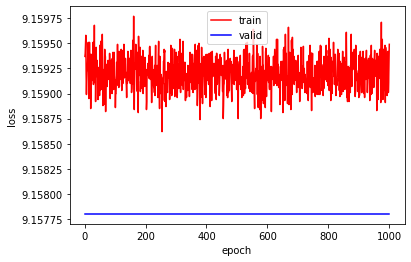

<Figure size 432x288 with 0 Axes>

In [38]:
x = np.arange(1, train_results.shape[0]+1)
plt.plot(x, train_results[:, 0], label='train', color='red')
plt.plot(x, valid_results[:, 0], label='valid', color='blue')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.savefig(opt.output_dir+'/loss.png')

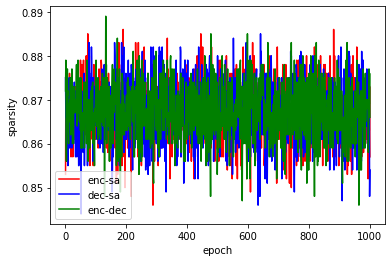

<Figure size 432x288 with 0 Axes>

In [39]:
plt.plot(x, sparsity_results[:, 0], label='enc-sa', color='red')
plt.plot(x, sparsity_results[:, 1], label='dec-sa', color='blue')
plt.plot(x, sparsity_results[:, 2], label='enc-dec', color='green')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('sparsity')
plt.show()
plt.savefig(opt.output_dir+'/sparsity.png')